# Compare obs to reanalyses/models
- **HadISST/PCMDI** (SST from Chongxing)
- **CERES** (LW/SW from Ryan Kramer)
- **OISST** (SST from NOAA)

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import linregress
import jo_regress
import xesmf as xe
from eofs.xarray import Eof as eof
import xeofs

# Load in reanalyses/model data
- ERA5 (sst/sw/lw)
- Glorys (sst)
- ESM4 (sst/sw/lw)

In [2]:
era = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc', chunks={})
glorys = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/Glorys/sst.nc', chunks={})
esm4_ocean = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ESM4/ds_ocean.nc', chunks={})
esm4_atm = xr.open_dataset('/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ESM4/ds_atm_new.nc', chunks={})

In [3]:
era20 = era.sel(time=slice('2000', None))
glorys20 = glorys.thetao.sel(time=slice('2000', None))
esm4_sst20 = esm4_ocean.tos.sel(time=slice('2000', None))
esm4_atm20 = esm4_atm.sel(time=slice('2000', None))

# Load in observation data
- HadISST
- PCMDI
- OISST
- CERES

In [4]:
#(dir: `/work/c1f/data/AM5_Inputs/downloads/`)
hadisst_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/HadISST_sst.nc', chunks={})
pcmdi_ds = xr.open_dataset('/work/c1f/data/AM5_Inputs/downloads/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc',
                           chunks={})
#https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html
oisst_ds = xr.open_dataset('sst.mon.mean.nc', chunks={})
#(dir: `/work/rjk/data/CERES/EBAF-All`)
ceres_ds = xr.open_dataset('/work/rjk/data/CERES/EBAF-All/CERES_EBAF_Ed4.2_Subset_200003-202312.nc', chunks={})

In [5]:
time_slice83 = dict(time=slice('1983', '2021-06-30'))
time_slice20 = dict(time=slice('2000', '2021-06-30'))

gom_h = dict(latitude=slice(31.5, 17.5), longitude=slice(-99,-80), )
gom_p = dict(lat=slice(17.5, 31), lon=slice(261,281))
gom_c = dict(lat=slice(17.5,31), lon=slice(261,281))
gom_o = dict(lat=slice(17.5,31.15), lon=slice(261,281))

#hadisst/pcmdi
hadisst83 = hadisst_ds.sst.sel(**gom_h).sel(**time_slice83)
hadisst20 = hadisst_ds.sst.sel(**gom_h).sel(**time_slice20)
pcmdi83 = pcmdi_ds.tosbcs.sel(**gom_p).sel(**time_slice83)
pcmdi20 = pcmdi_ds.tosbcs.sel(**gom_p).sel(**time_slice20)

#ceres
ceres = ceres_ds.sel(**gom_c).sel(**time_slice20)
#sfc_sw_down_all - sfc_sw_up_all = sfc_net_sw_all
sw_ceres = ceres.sfc_net_sw_all_mon - ceres.toa_sw_all_mon
lw_ceres = ceres.sfc_net_lw_all_mon - ceres.toa_lw_all_mon

#oisst  
oisst83 = oisst_ds.sst.sel(**gom_o).sel(**time_slice83)
oisst20 = oisst_ds.sst.sel(**gom_o).sel(**time_slice20)

# Plot time average of the fields

In [6]:
def plot_mean(da, cmap_choice, cbar_label, var_title, var_name, vmin=None, vmax=None, quiver=True, model=None):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if model=='pcmdi':
        im = ax.pcolormesh(da.lon, da.lat, da.mean('time'), transform=ccrs.PlateCarree(), 
                           vmin=vmin, vmax=vmax, cmap=cmap_choice)
    elif model=='esm4':
        im = ax.pcolormesh(da.xh, da.yh, da.mean('time'), transform=ccrs.PlateCarree(), 
                           vmin=vmin, vmax=vmax, cmap=cmap_choice)        
    else:
        im = ax.pcolormesh(da.longitude, da.latitude, da.mean('time'), transform=ccrs.PlateCarree(), 
                           vmin=vmin, vmax=vmax, cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    n,s,e,w = 31, 28, -85, -95
    ax.plot([w, e], [s, s], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([w, e], [n, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([w, w], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([e, e], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    plt.title(f'Time-averaged {var_title}', fontsize=20)
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/time-mean/time-mean_{var_name}.pdf');        

## Obs

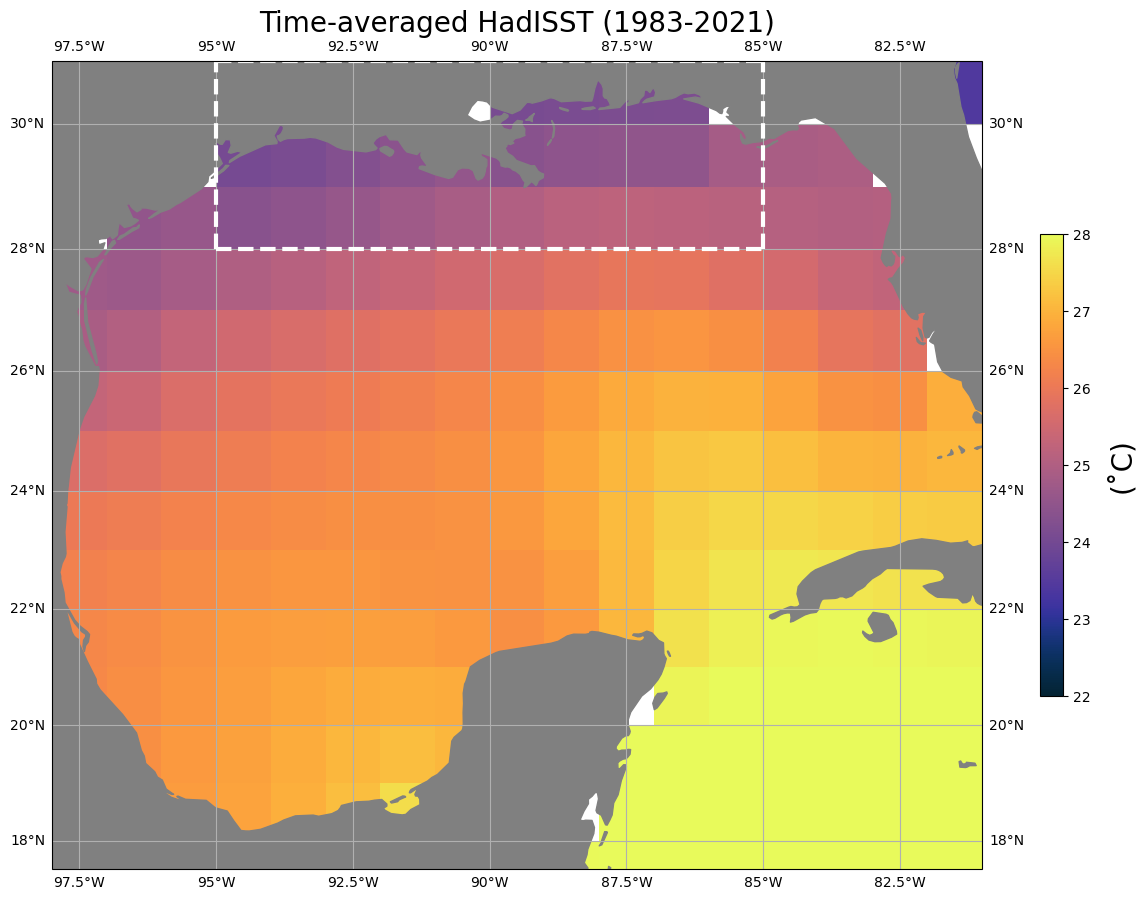

In [7]:
plot_mean(hadisst83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST (1983-2021)', var_name='hadisst83', vmin=22, vmax=28)

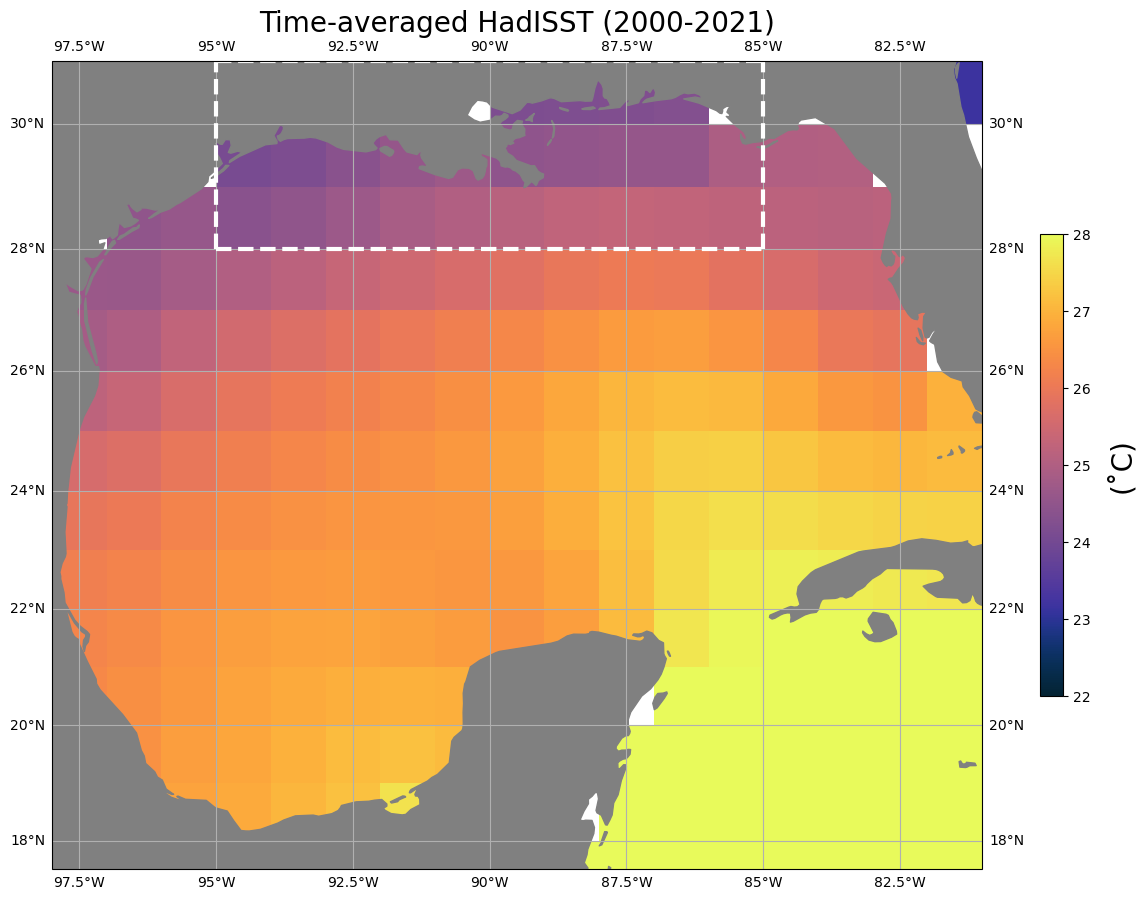

In [8]:
plot_mean(hadisst20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST (2000-2021)', var_name='hadisst20', vmin=22, vmax=28)

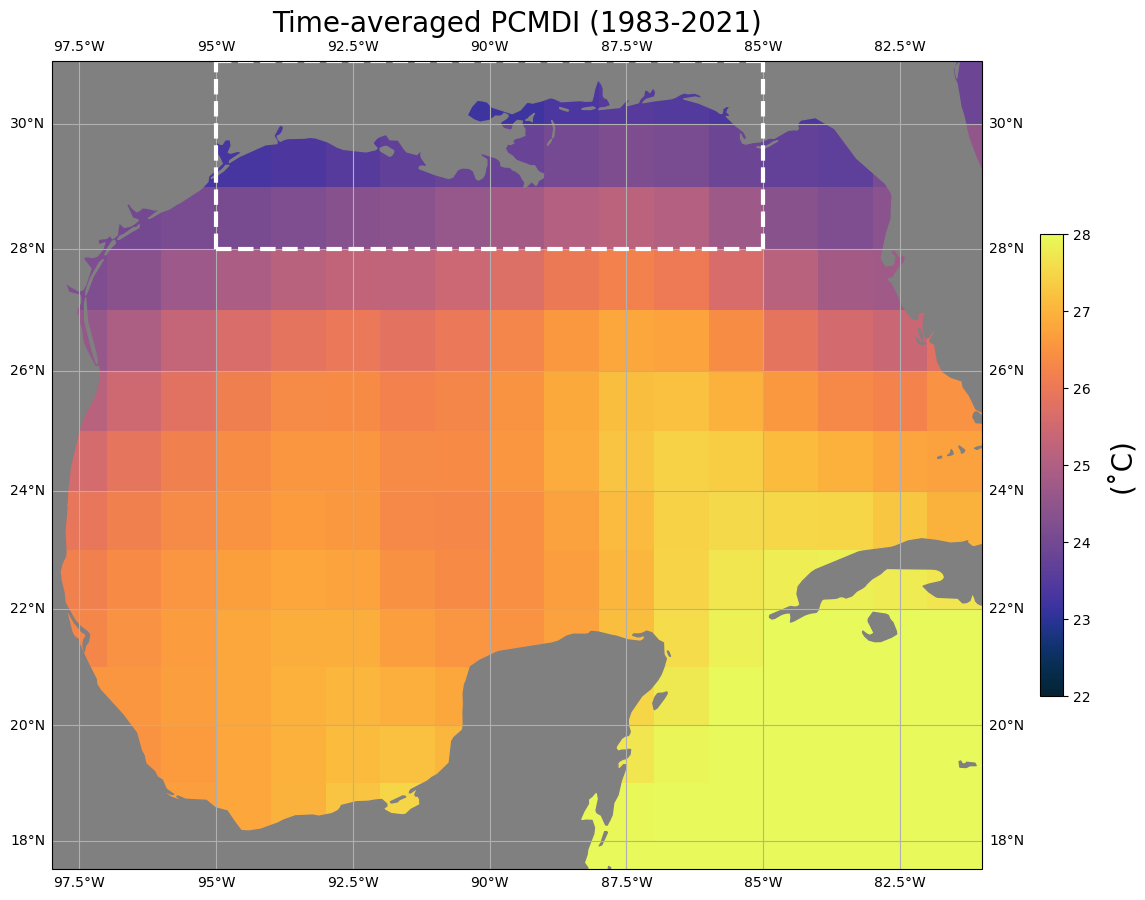

In [9]:
plot_mean(pcmdi83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='PCMDI (1983-2021)', var_name='pcmdi83', vmin=22, vmax=28, model='pcmdi')

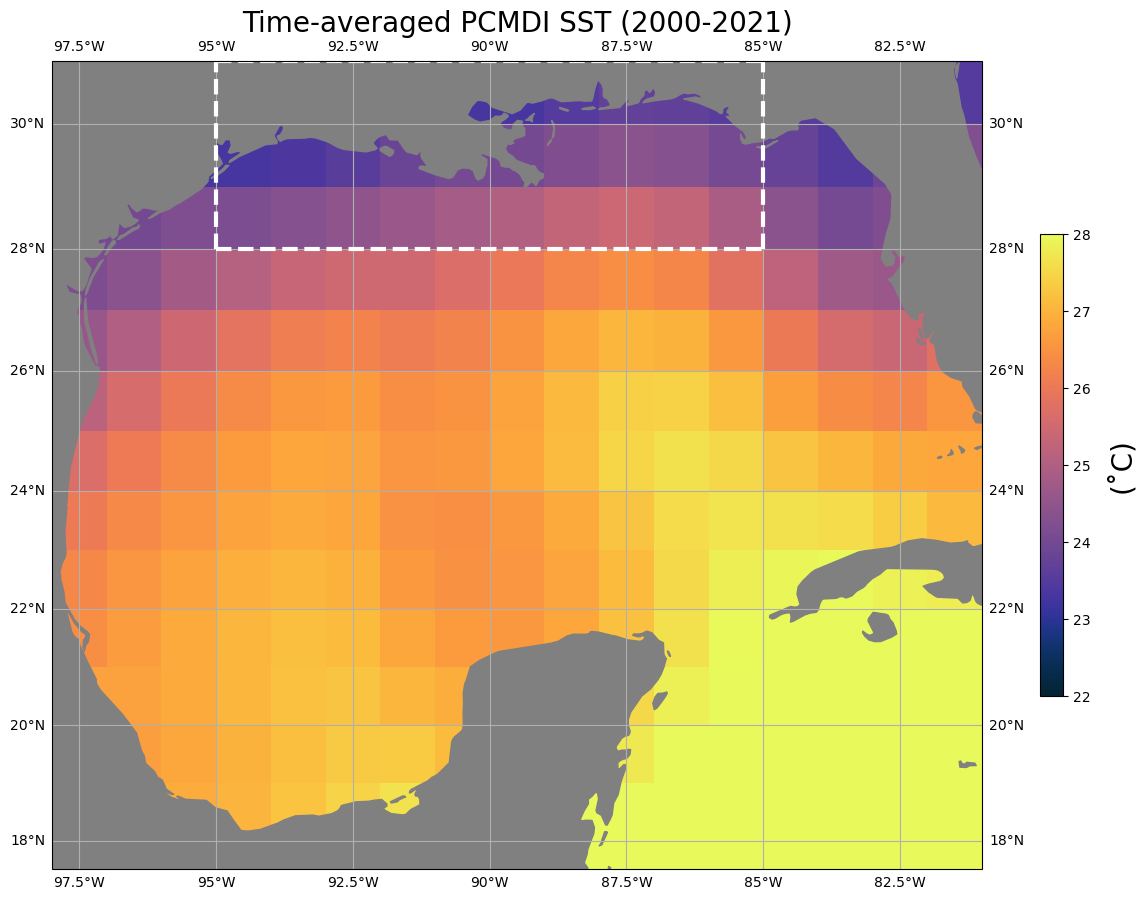

In [10]:
plot_mean(pcmdi20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='PCMDI SST (2000-2021)', var_name='pcmdi20', vmin=22, vmax=28, model='pcmdi')

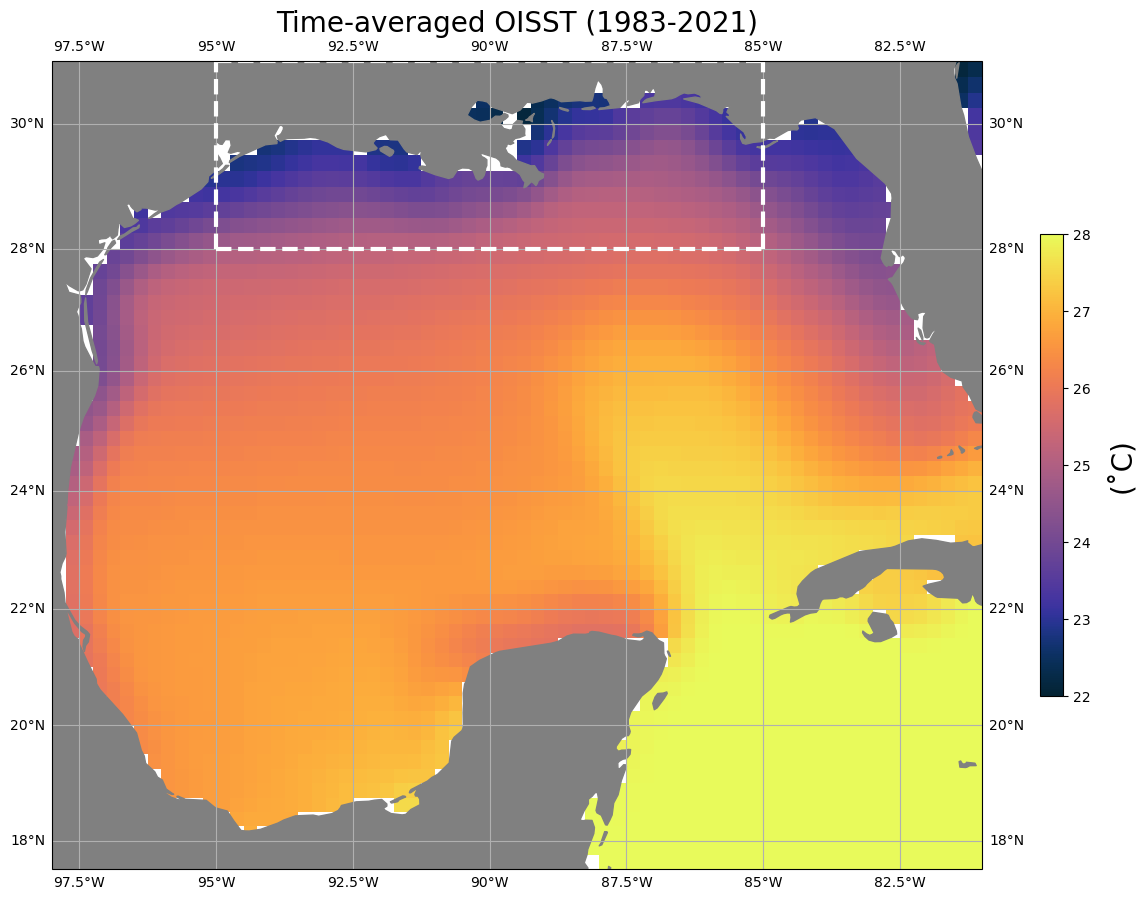

In [11]:
plot_mean(oisst83, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='OISST (1983-2021)', var_name='oisst83', vmin=22, vmax=28, model='pcmdi')

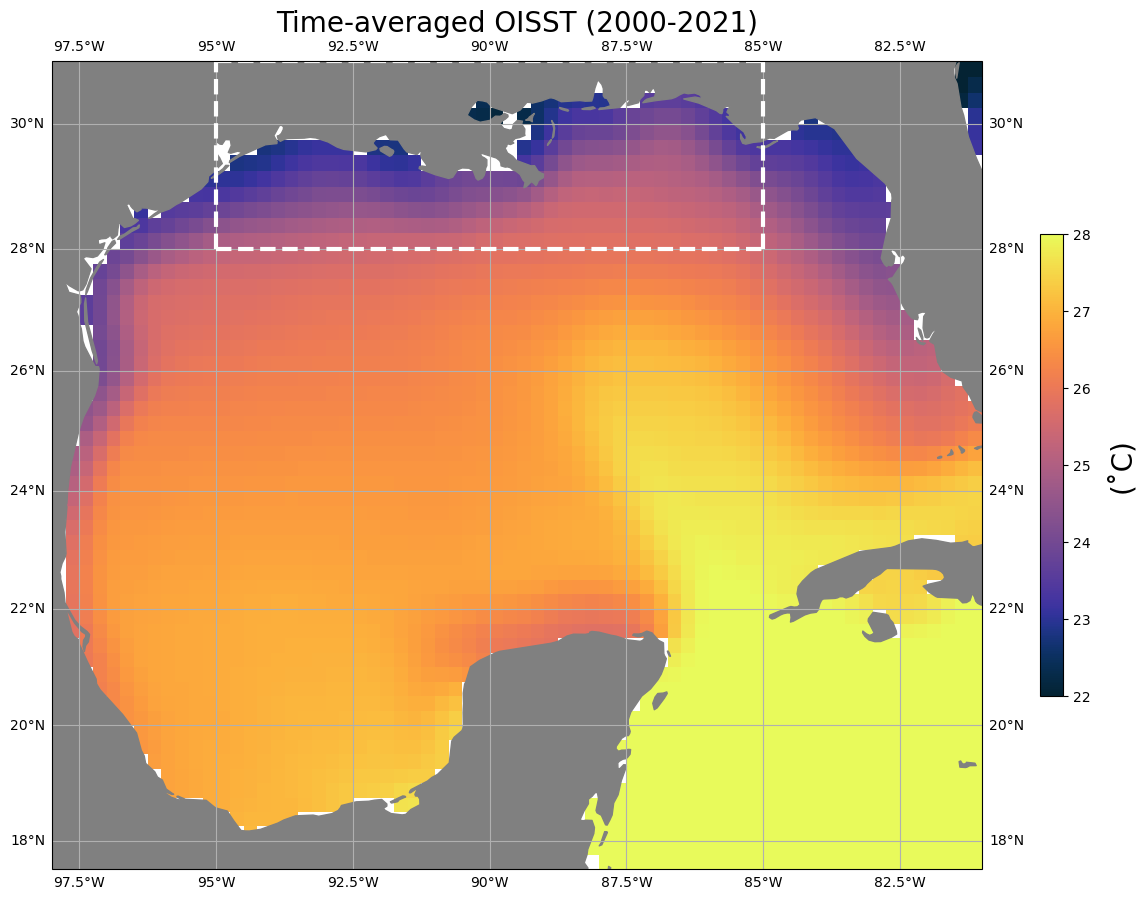

In [12]:
plot_mean(oisst20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='OISST (2000-2021)',  var_name='oisst20', vmin=22, vmax=28, model='pcmdi')

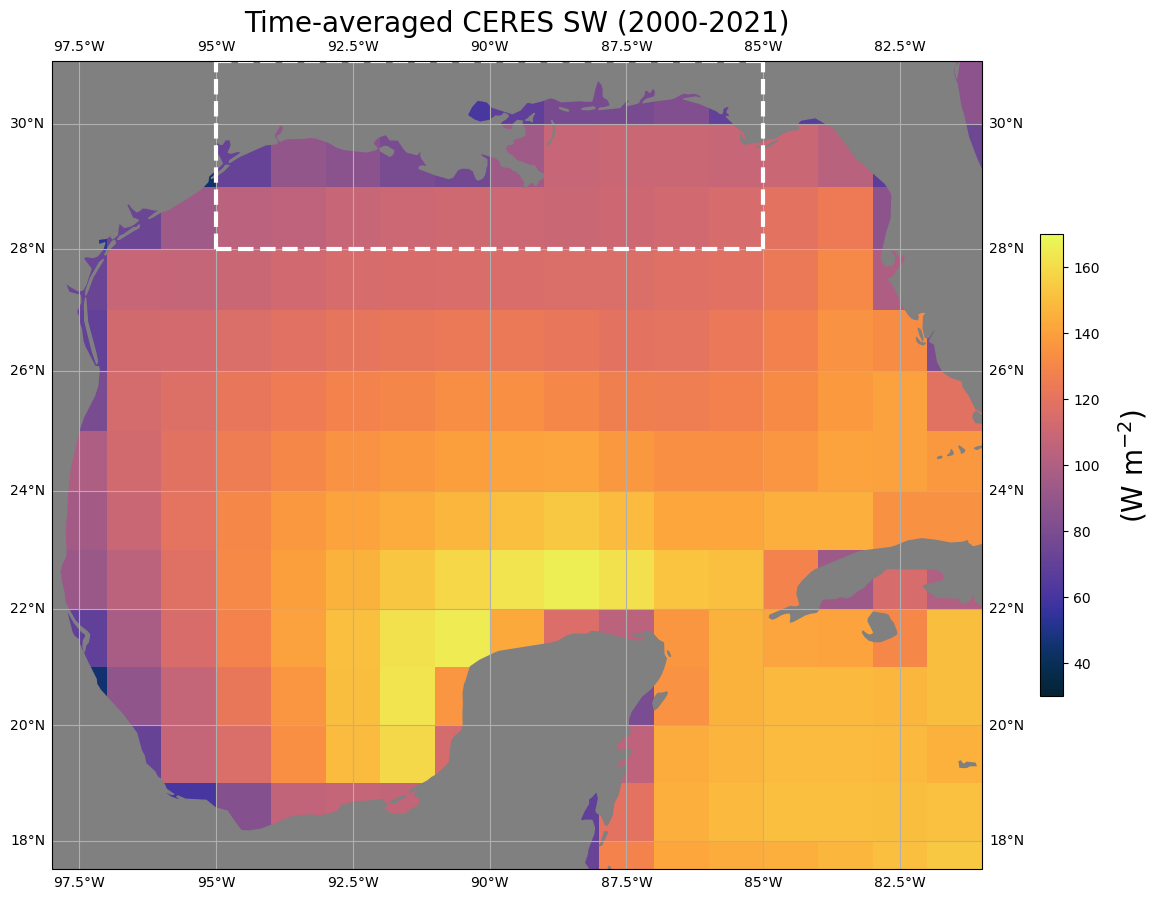

In [13]:
plot_mean(sw_ceres, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
          var_title='CERES SW (2000-2021)', var_name='ceres_sw', vmin=30, vmax=170, model='pcmdi')

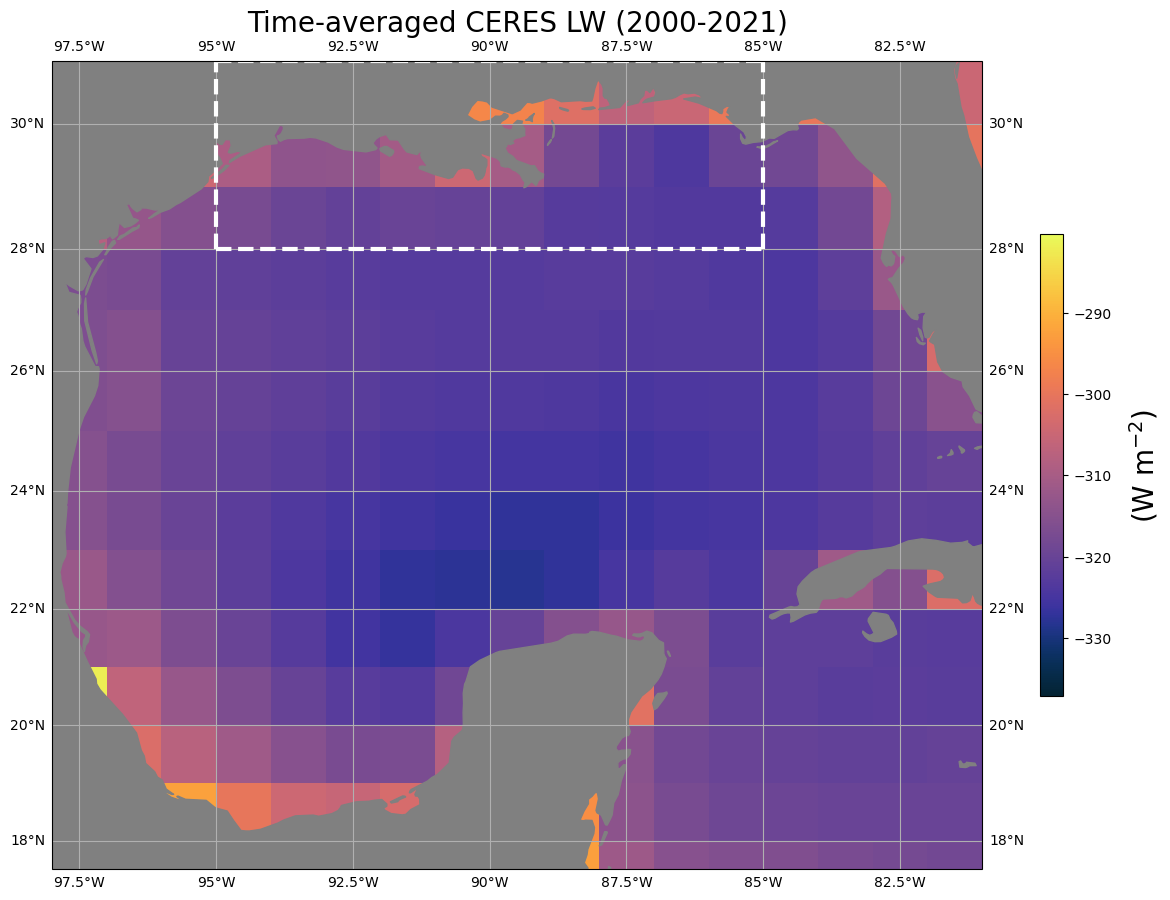

In [14]:
plot_mean(lw_ceres, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)', 
                var_title='CERES LW (2000-2021)', var_name='ceres_lw', model='pcmdi')

## Reanalyses

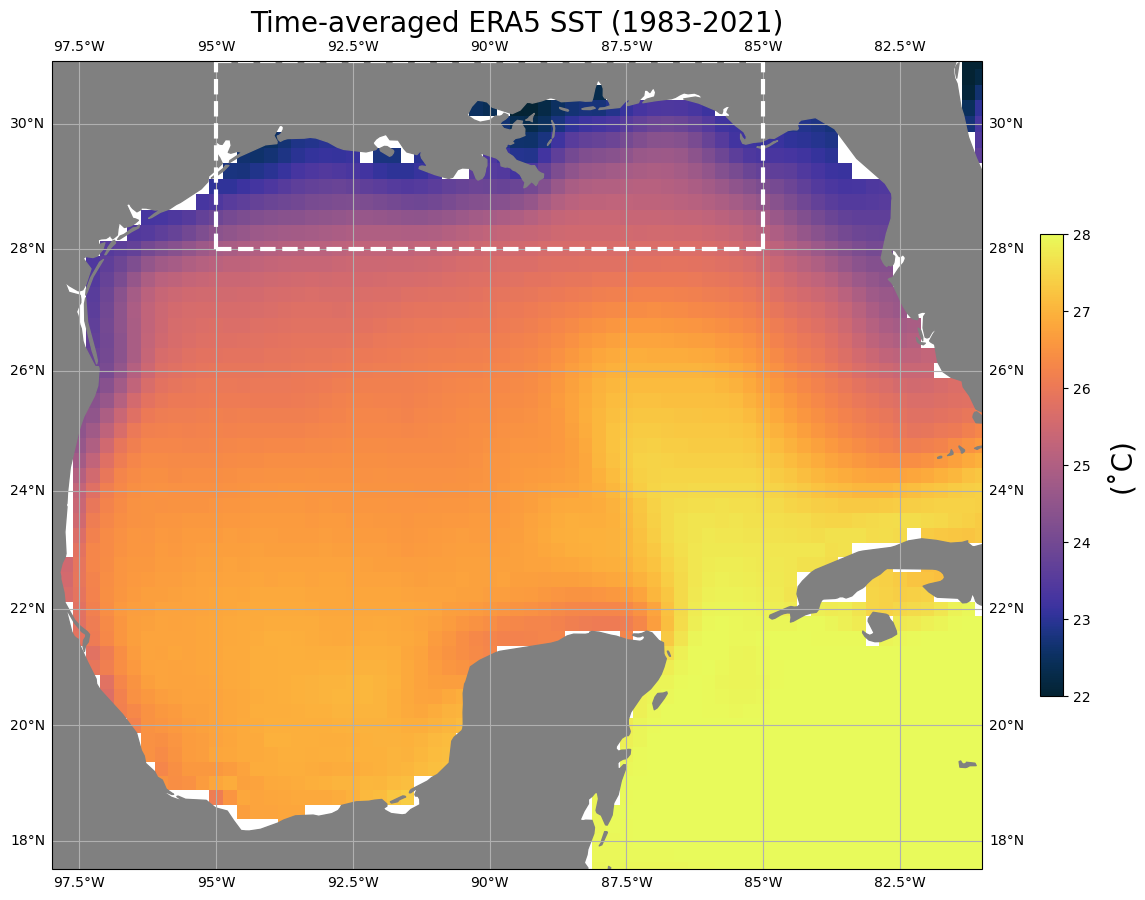

In [15]:
plot_mean(era.sst, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='ERA5 SST (1983-2021)', var_name='era_sst', vmin=22, vmax=28)

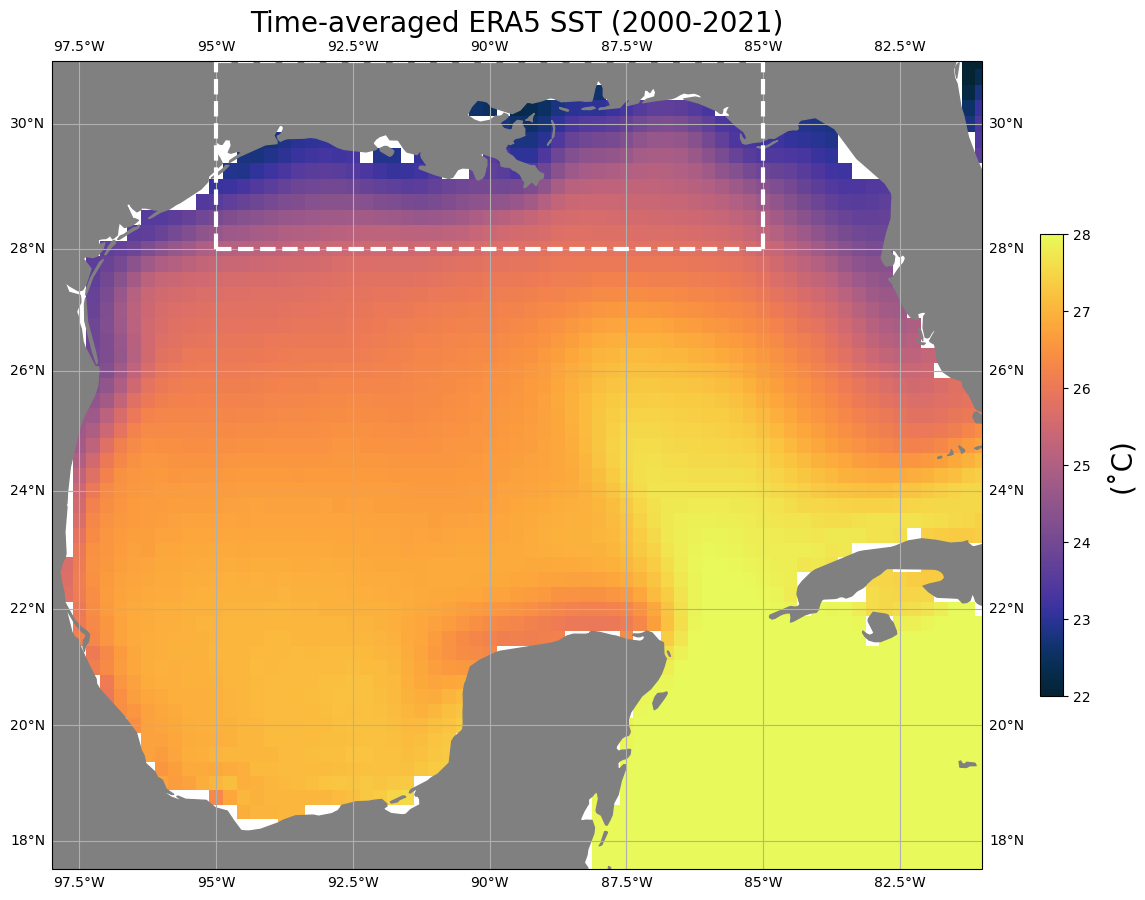

In [16]:
plot_mean(era20.sst, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='ERA5 SST (2000-2021)', var_name='era_sst20', vmin=22, vmax=28)

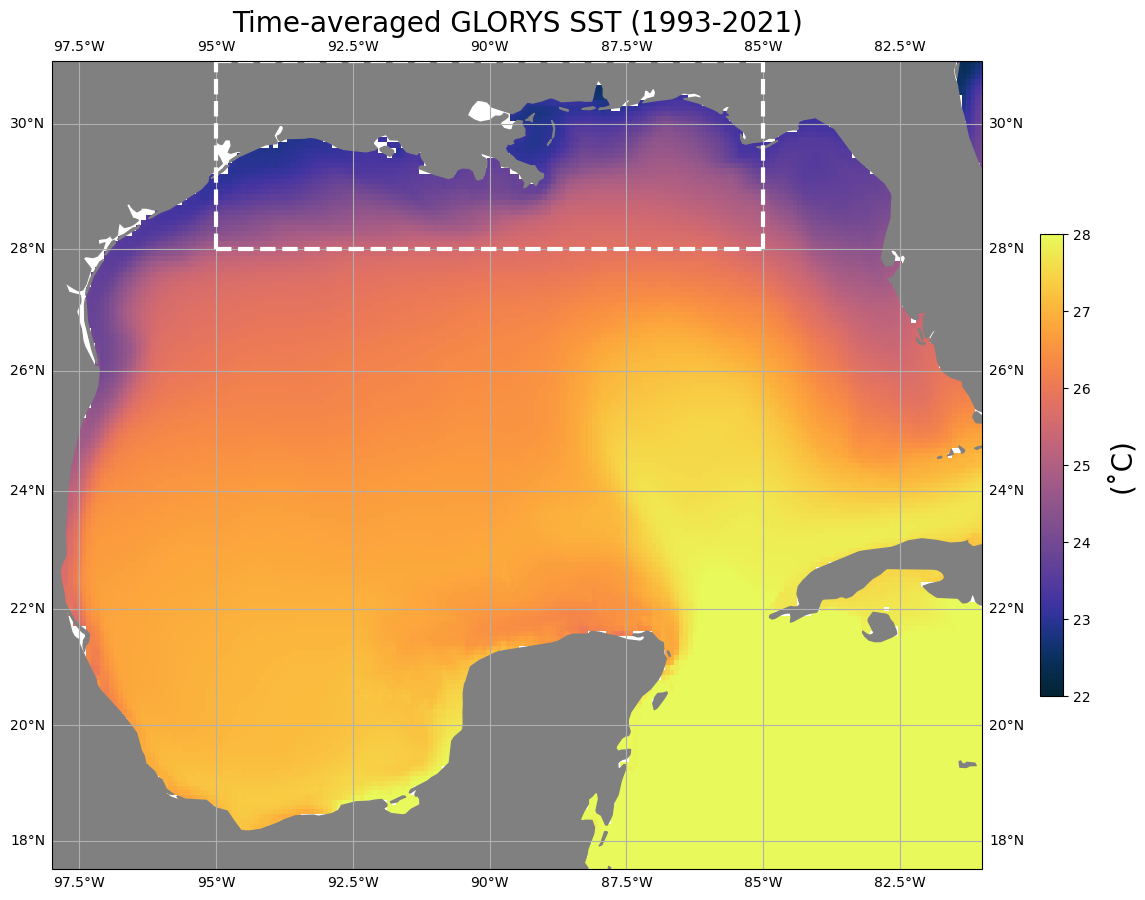

In [17]:
plot_mean(glorys.thetao, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='GLORYS SST (1993-2021)', var_name='glorys_sst', vmin=22, vmax=28)

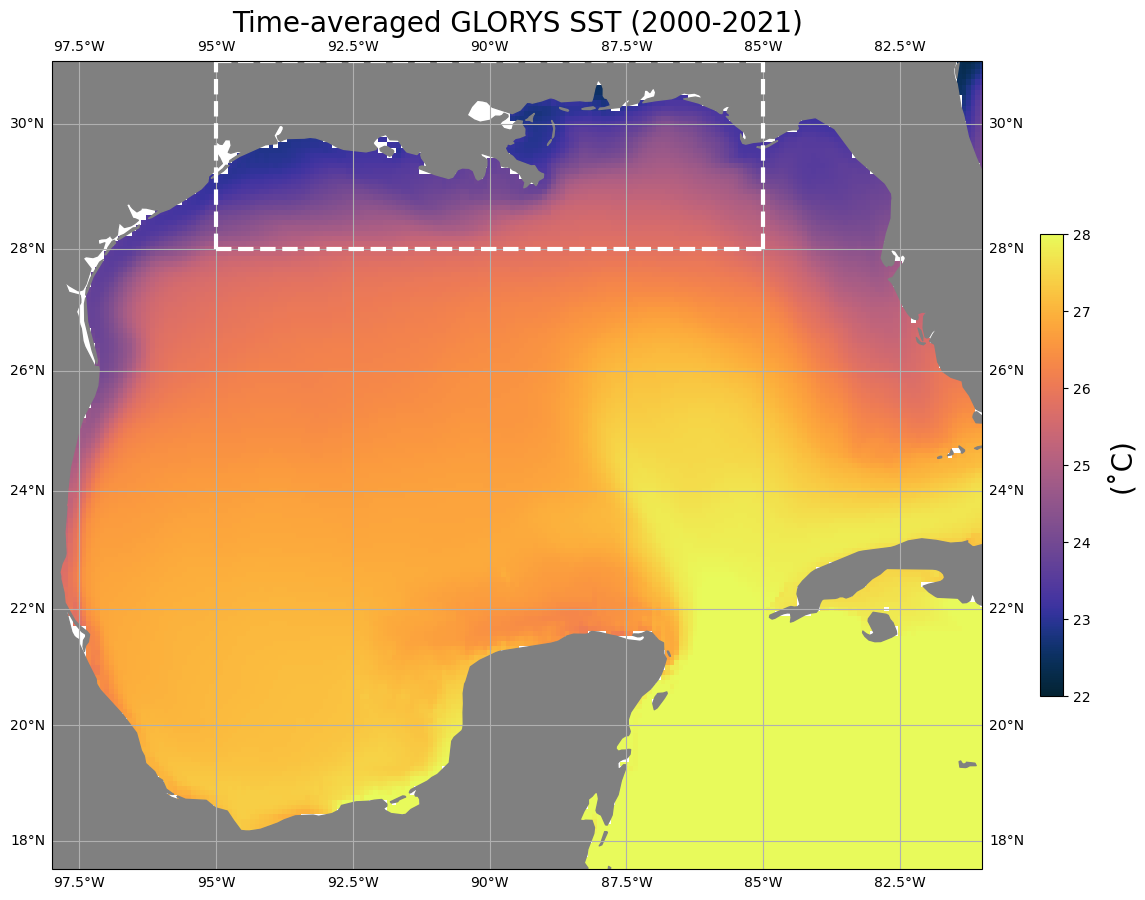

In [18]:
plot_mean(glorys20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='GLORYS SST (2000-2021)', var_name='glorys_sst20', vmin=22, vmax=28)

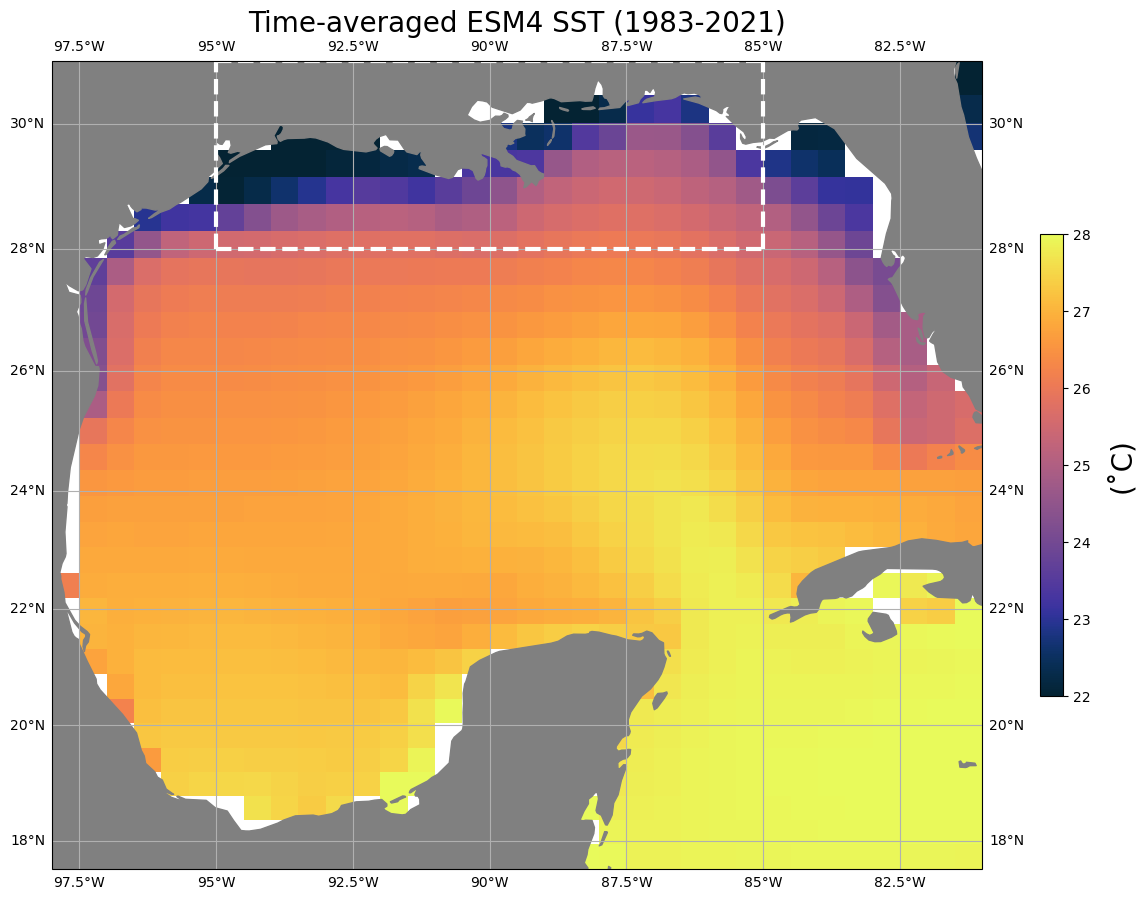

In [19]:
plot_mean(esm4_ocean.tos, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='ESM4 SST (1983-2021)', var_name='esm_sst', vmin=22, vmax=28, model='esm4')

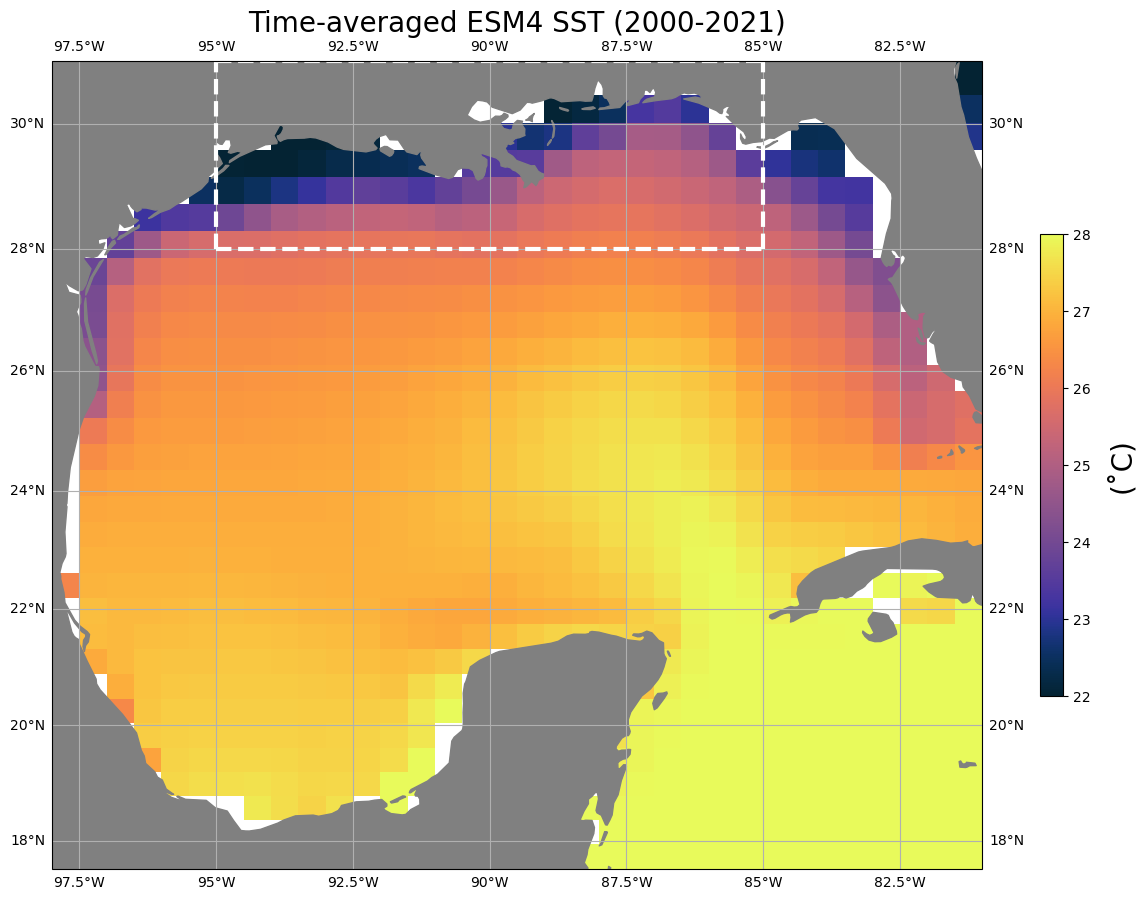

In [20]:
plot_mean(esm4_sst20, cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='ESM4 SST (2000-2021)', var_name='esm_sst20', vmin=22, vmax=28, model='esm4')

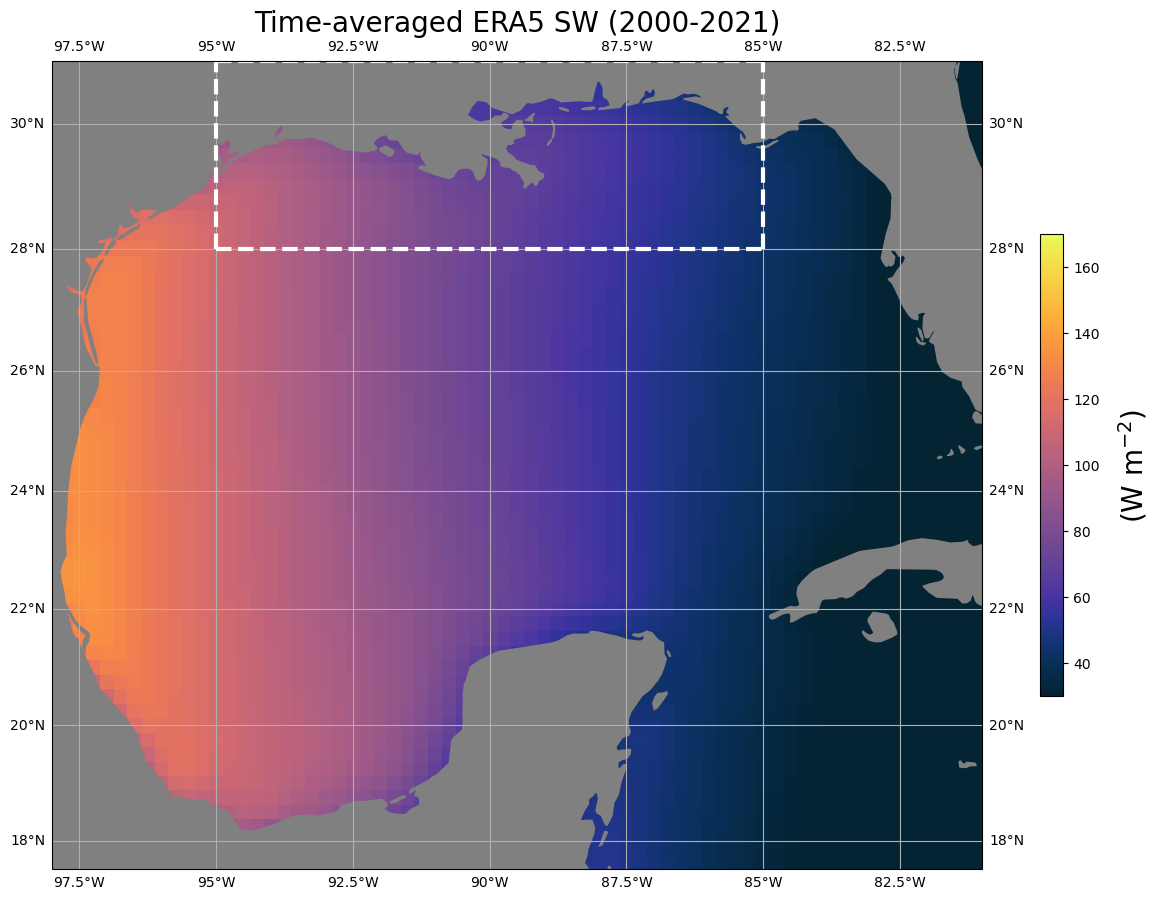

In [21]:
plot_mean(era20.ssr, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)',
          var_title='ERA5 SW (2000-2021)', var_name='era_sw', vmin=30, vmax=170)

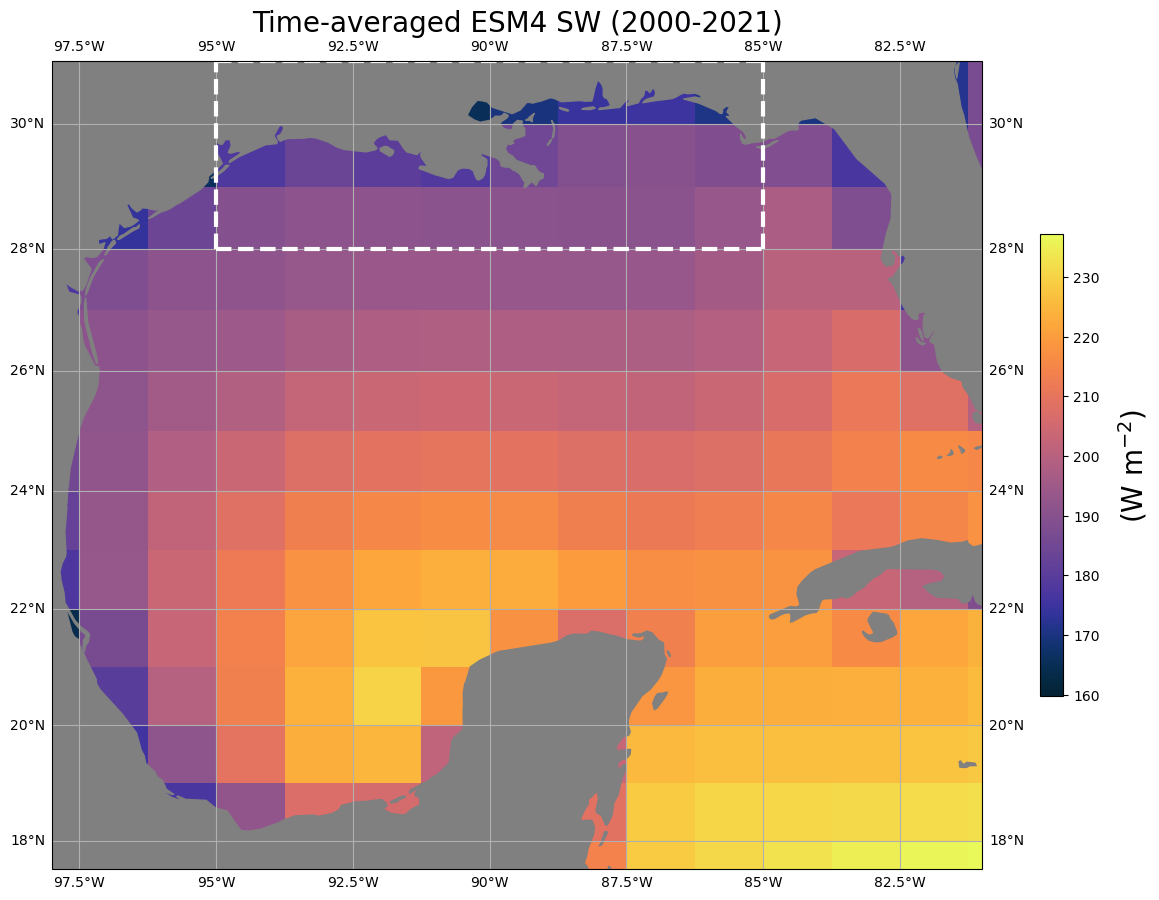

In [22]:
plot_mean(esm4_atm20.rss, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)',
          var_title='ESM4 SW (2000-2021)', var_name='esm4_sw', model='pcmdi')

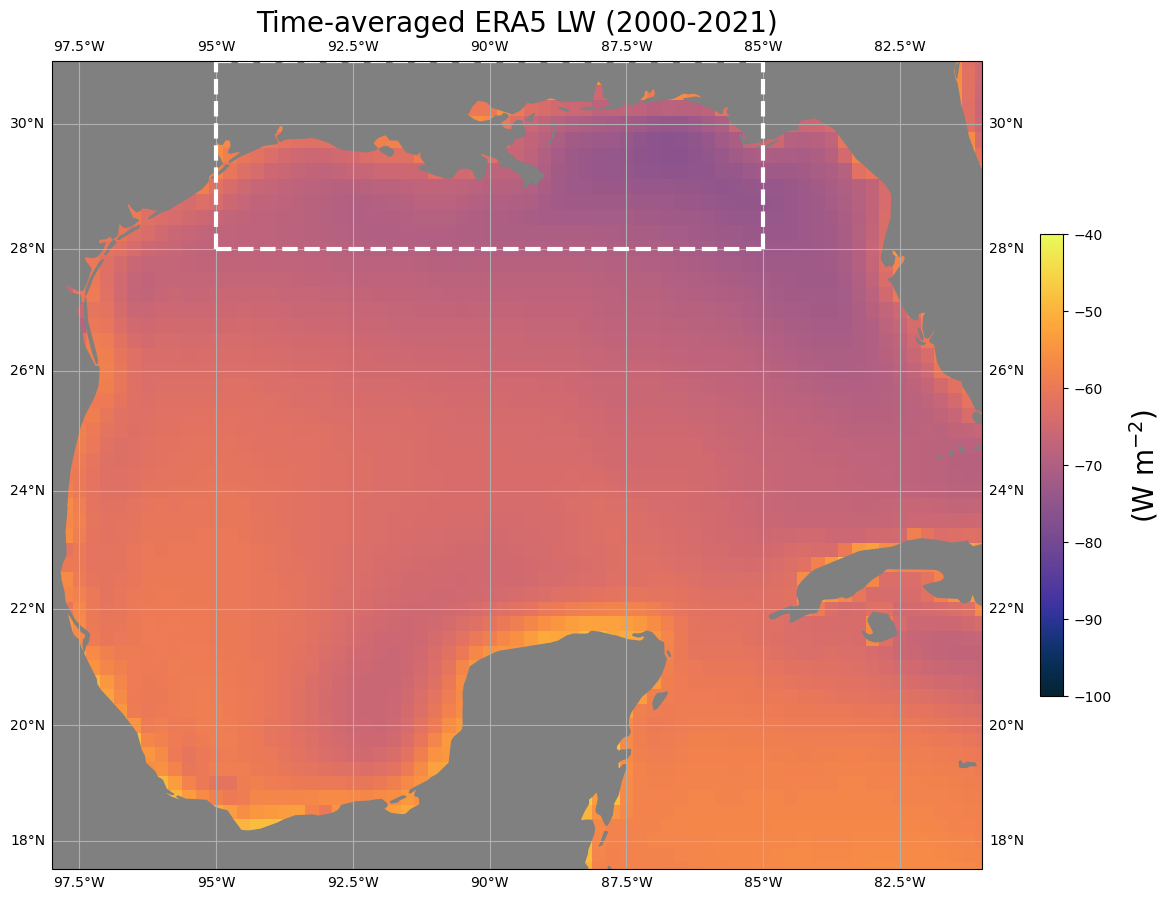

In [23]:
plot_mean(era20.str, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)',
          var_title='ERA5 LW (2000-2021)', var_name='era_lw', vmin=-100, vmax=-40)

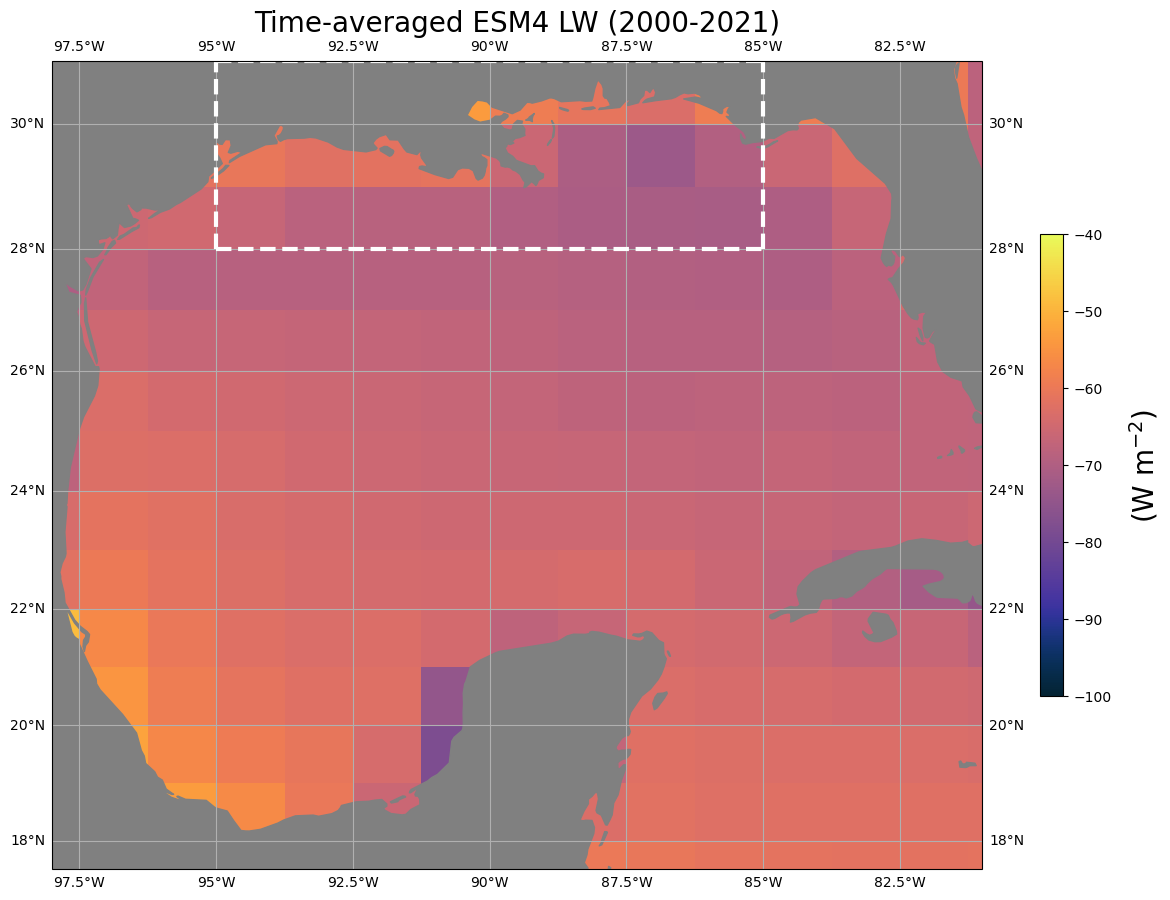

In [24]:
plot_mean(esm4_atm20.rls, cmap_choice=cmocean.cm.thermal, cbar_label=r'(W m$^{-2}$)',
          var_title='ESM4 LW (2000-2021)', var_name='esm4_lw', vmin=-100, vmax=-40, model='pcmdi')

# Calculate linear trend for each data field

In [6]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [7]:
#obs 
trend_hadisst83 = trending(hadisst83)
trend_hadisst20 = trending(hadisst20)
trend_pcmdi83 = trending(pcmdi83)
trend_pcmdi20 = trending(pcmdi20)
trend_oisst83 = trending(oisst83)
trend_oisst20 = trending(oisst20)

trend_lw = trending(lw_ceres)
trend_sw = trending(sw_ceres)

#reanlyses
trend_sst_era83 = trending(era.sst)
trend_sst_esm483 = trending(esm4_ocean.tos)
trend_sst_glorys = trending(glorys.thetao)
trend_sst_era20 = trending(era20.sst)
trend_sst_esm420 = trending(esm4_sst20)
trend_sst_glorys20 = trending(glorys20)

trend_sw_era83 = trending(era.ssr)
trend_sw_esm483 = trending(esm4_atm.rss)
trend_sw_era20 = trending(era20.ssr)
trend_sw_esm420 = trending(esm4_atm20.rss)
trend_lw_esm420 = trending(esm4_atm20.rls)
trend_lw_era20 = trending(era20.str)
trend_lw_era83 = trending(era.str)
trend_lw_esm483 = trending(esm4_atm.rls)

## Trends (spatial maps)

In [8]:
def plot_trend(da, title, var_title, cbar_label, v_min, v_max, cmap_choice, coord_name=None):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    d = da.polyfit_coefficients[0]
    norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
    
    if coord_name=='lon':
        im = ax.pcolormesh(d.lon, d.lat, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
    elif coord_name=='xh':
        im = ax.pcolormesh(da.xh, da.yh, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)        
    else:
        im = ax.pcolormesh(da.longitude, da.latitude, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)    
    
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
    
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    n,s,e,w = 31, 28, -85, -95
    ax.plot([w, e], [s, s], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([w, e], [n, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([w, w], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax.plot([e, e], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    plt.title(f'{title}', fontsize=26);
    plt.savefig(f'/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend/trend_spatio_{var_title}.pdf');

## Obs

In [9]:
print('Max: ', trend_hadisst83.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_hadisst83.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.01833435282533515 C/yr 
Min:  -0.02993142054631205 C/yr


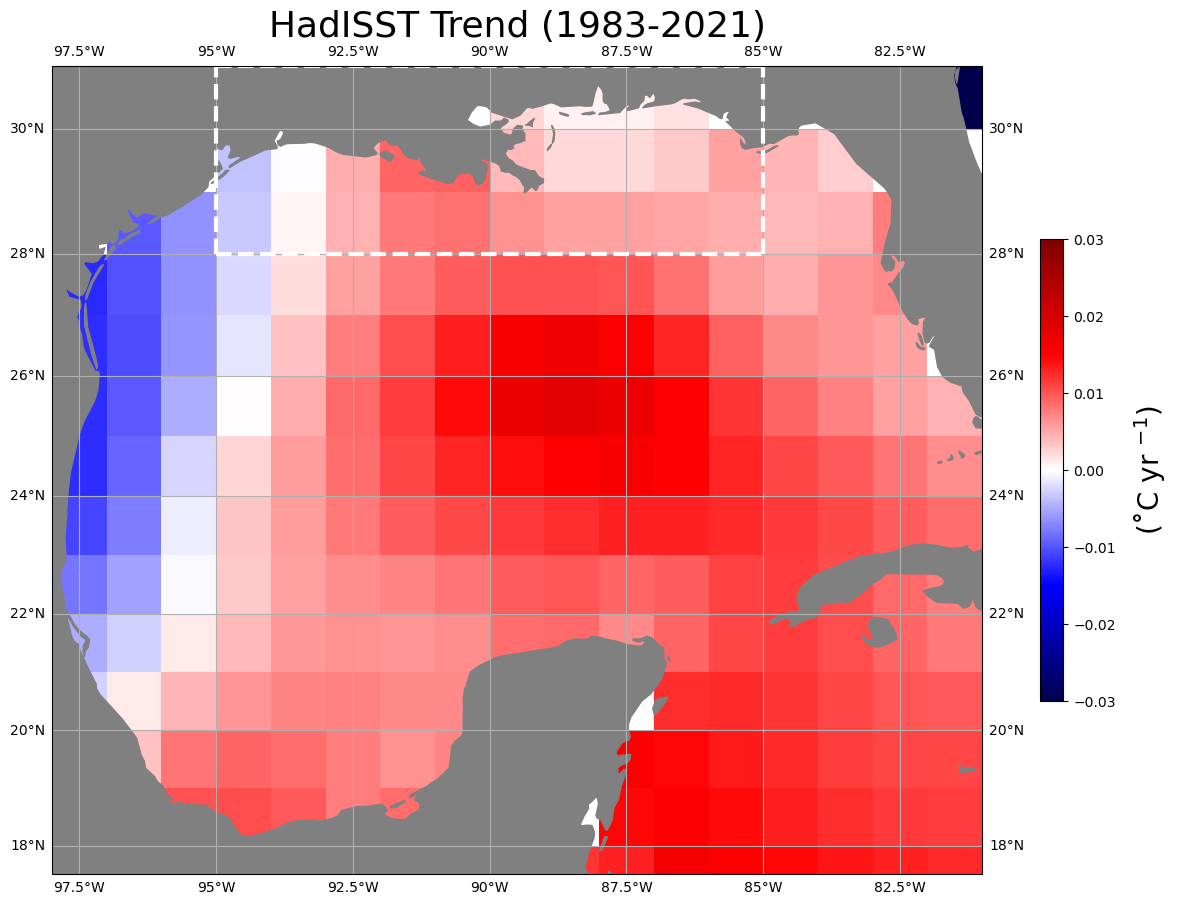

In [10]:
plot_trend(trend_hadisst83, 'HadISST Trend (1983-2021)', 'hadISST83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic')

In [30]:
print('Max: ', trend_hadisst20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_hadisst20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.02023062552522697 C/yr 
Min:  -0.0320478285321525 C/yr


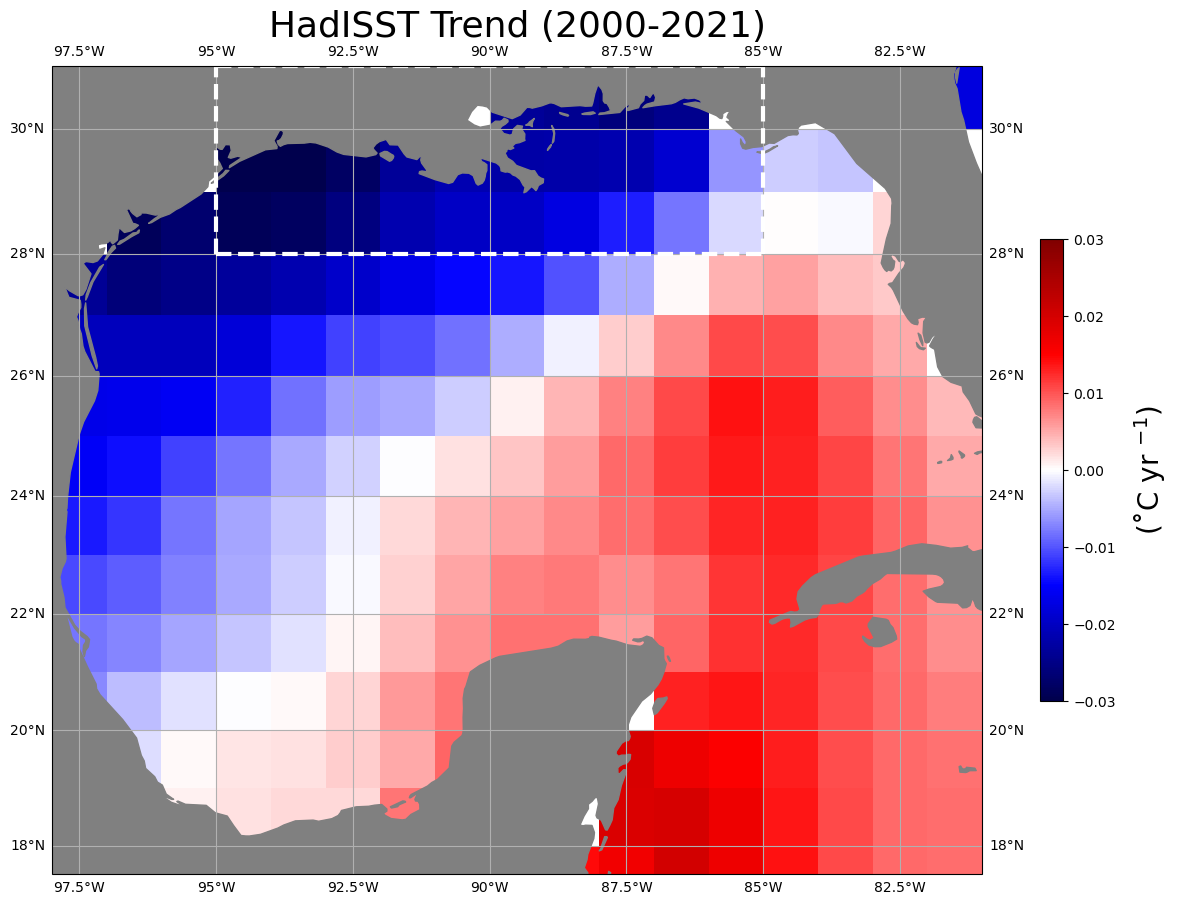

In [11]:
plot_trend(trend_hadisst20, 'HadISST Trend (2000-2021)', 'hadISST20', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic')

In [32]:
print('Max: ', trend_pcmdi83.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_pcmdi83.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.026899530820036332 C/yr 
Min:  -0.04714391106053435 C/yr


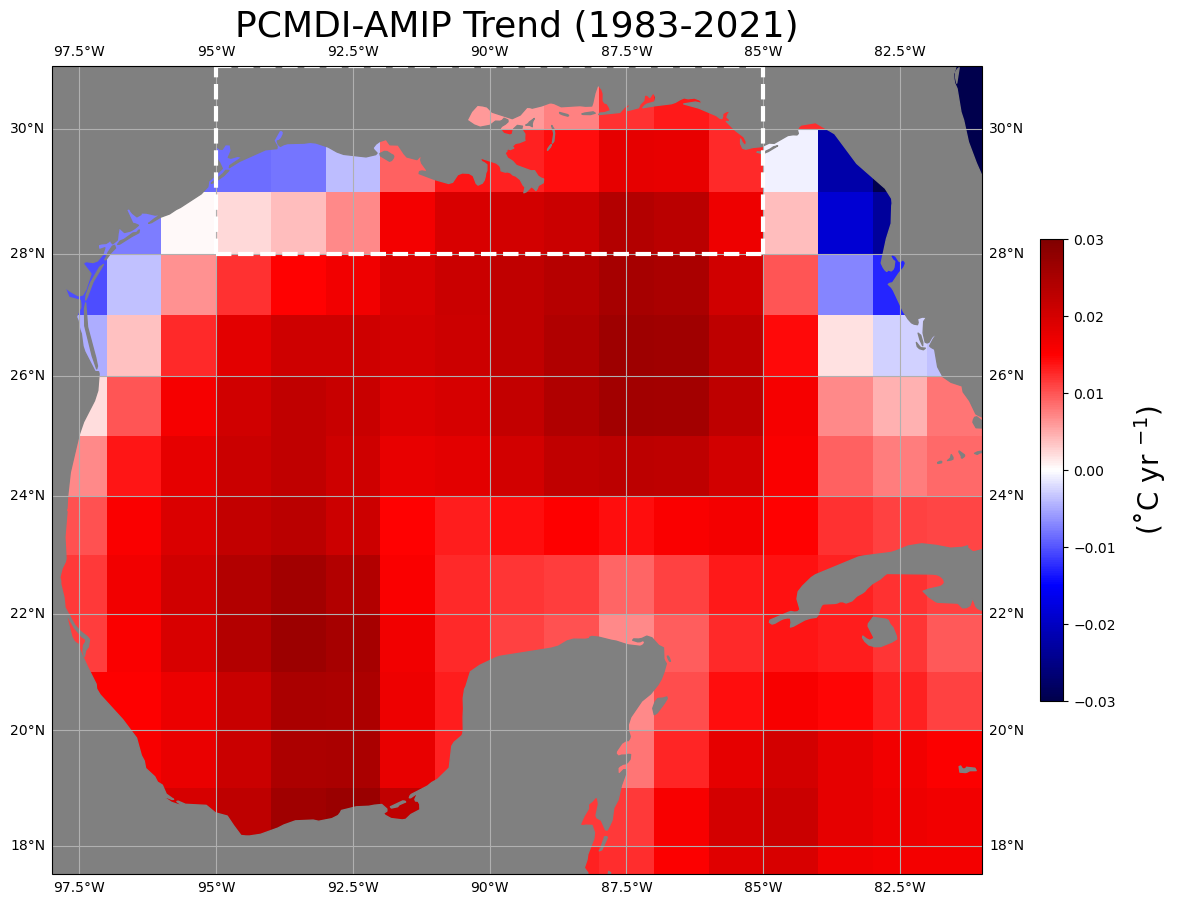

In [14]:
plot_trend(trend_pcmdi83, 'PCMDI-AMIP Trend (1983-2021)', 'pcmdi83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='lon')

In [34]:
print('Max: ', trend_pcmdi20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_pcmdi20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.03481186964227752 C/yr 
Min:  -0.033306981263895176 C/yr


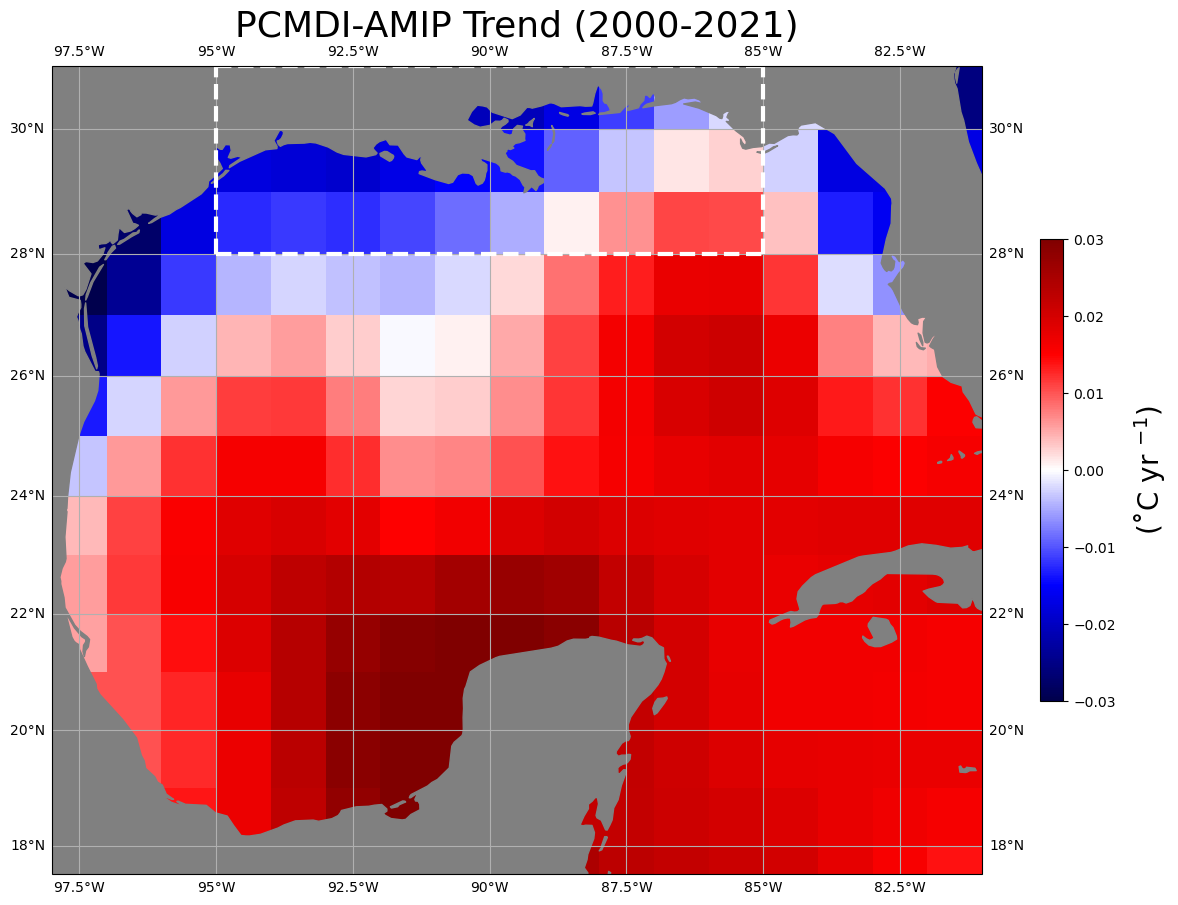

In [35]:
plot_trend(trend_pcmdi20, 'PCMDI-AMIP Trend (2000-2021)', 'pcmdi20', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='lon')

In [36]:
print('Max: ', trend_oisst83.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_oisst83.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.032854535801690704 ˚C/yr 
Min:  -0.049295191050542204 ˚C/yr


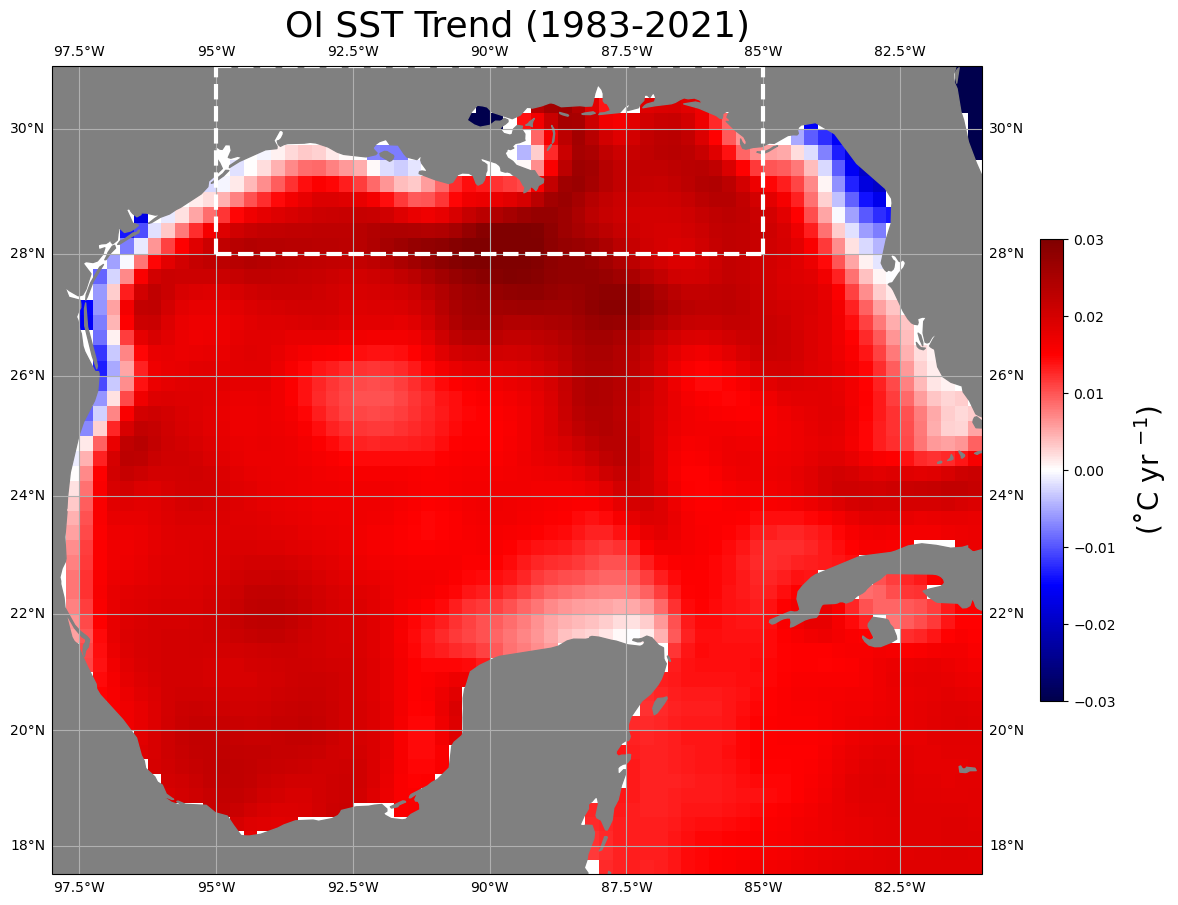

In [15]:
plot_trend(trend_oisst83, 'OI SST Trend (1983-2021)', 'oisst83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='lon')

In [38]:
print('Max: ', trend_oisst20.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_oisst20.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.06862339793053604 ˚C/yr 
Min:  -0.1023910518152938 ˚C/yr


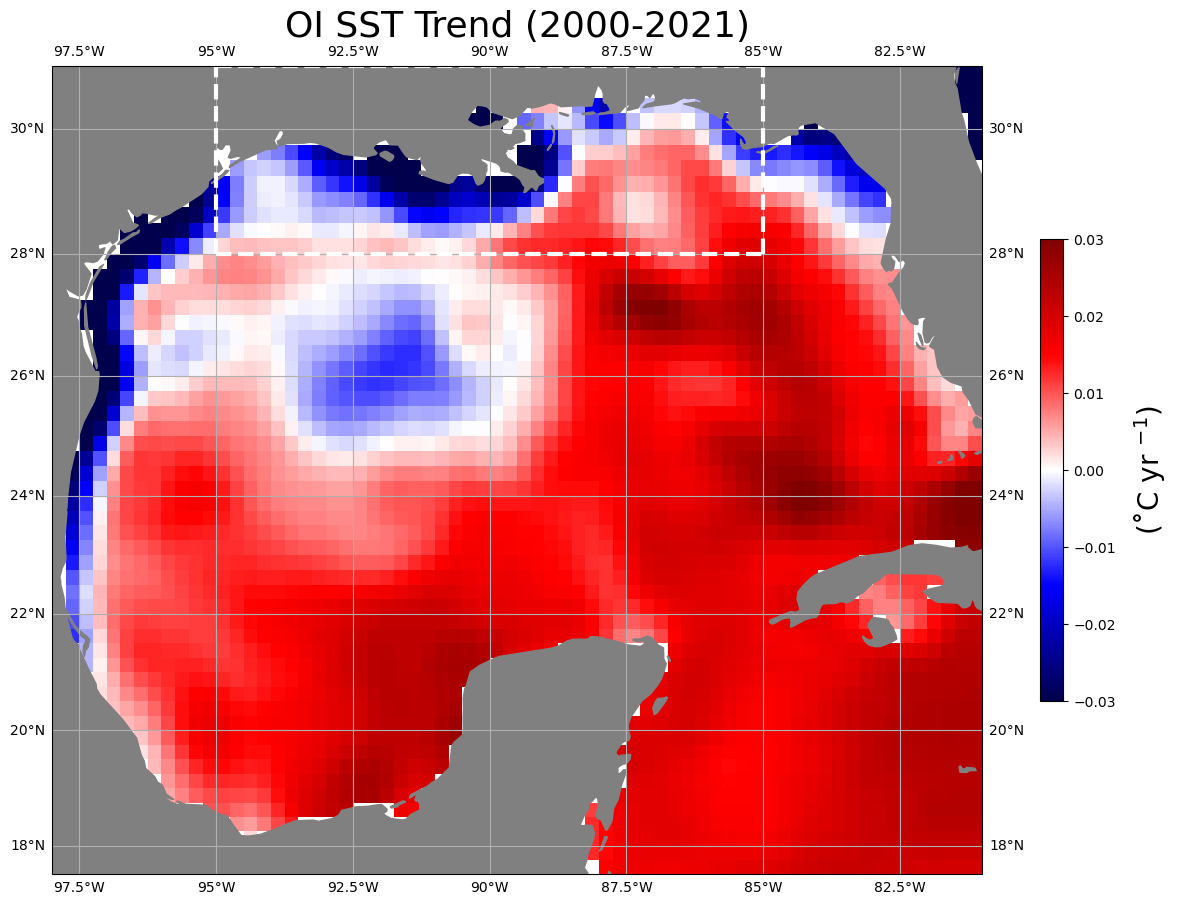

In [16]:
plot_trend(trend_oisst20, 'OI SST Trend (2000-2021)', 'oisst20', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='lon')

In [40]:
print('Max: ', trend_lw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.5469404982012692 W/m2/yr 
Min:  -0.365676785107722 W/m2/yr


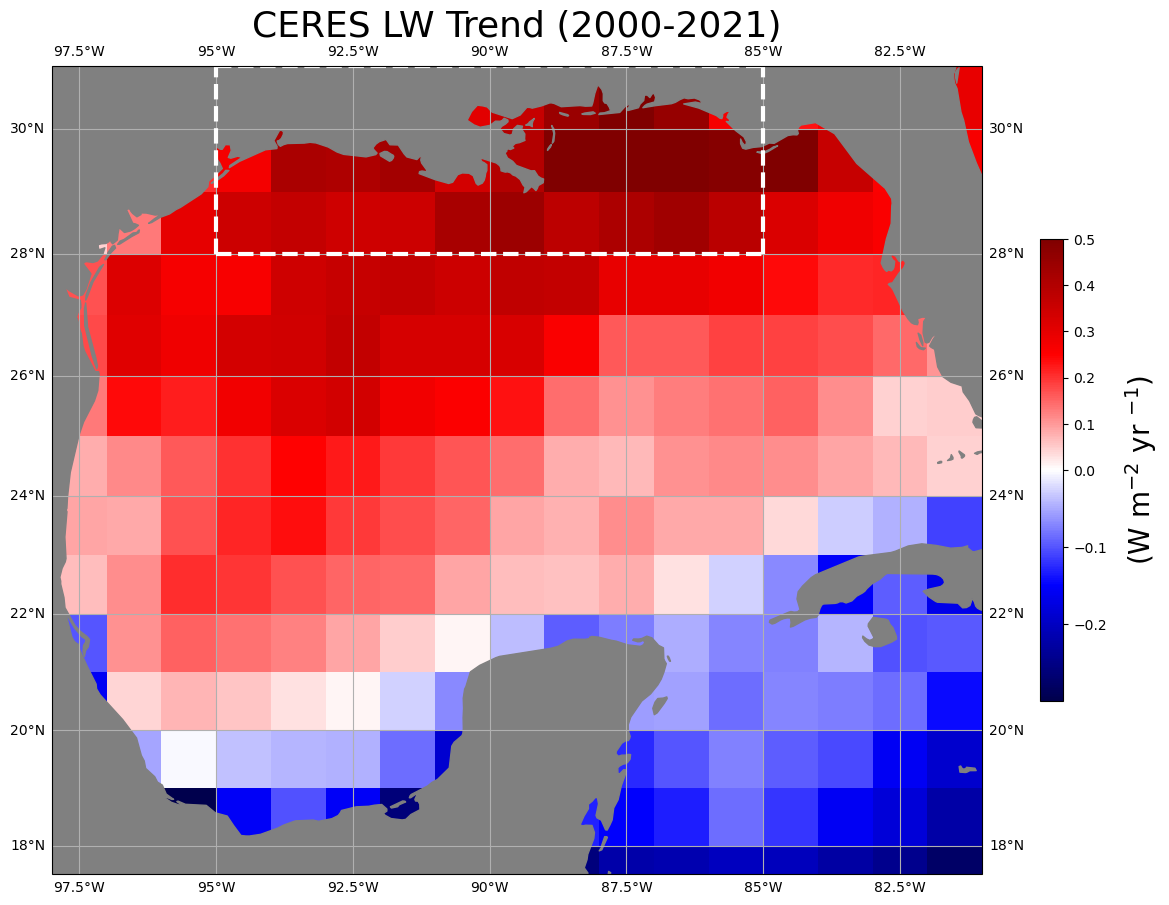

In [41]:
plot_trend(trend_lw, 'CERES LW Trend (2000-2021)', 'ceres_lw', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic', coord_name='lon')

In [42]:
print('Max: ', trend_sw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.811501126582812 W/m2/yr 
Min:  -0.9422240900764515 W/m2/yr


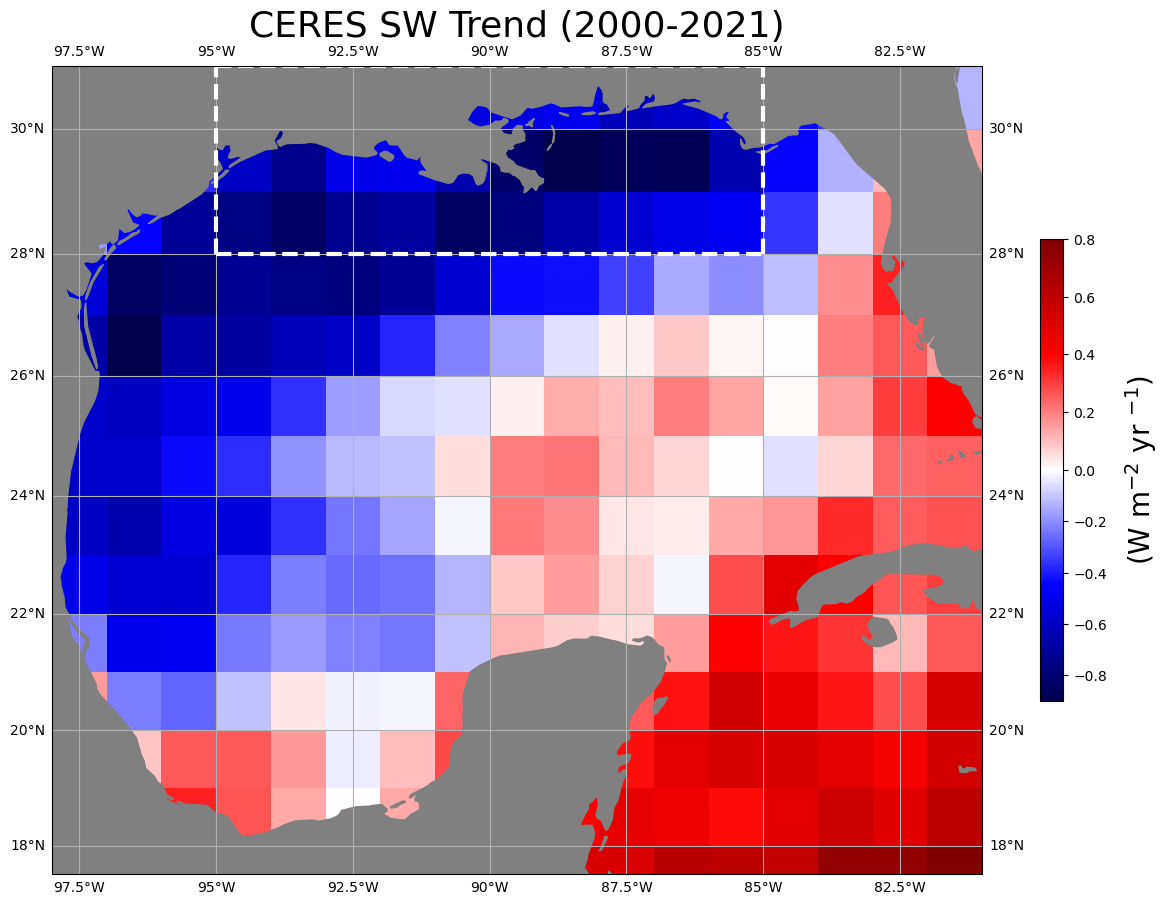

In [43]:
plot_trend(trend_sw, 'CERES SW Trend (2000-2021)', 'ceres_sw', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic', coord_name='lon')

## Reanalyses

In [44]:
print('Max: ', trend_sst_era83.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_era83.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.03893065317439742 C/yr 
Min:  -0.01346966940381779 C/yr


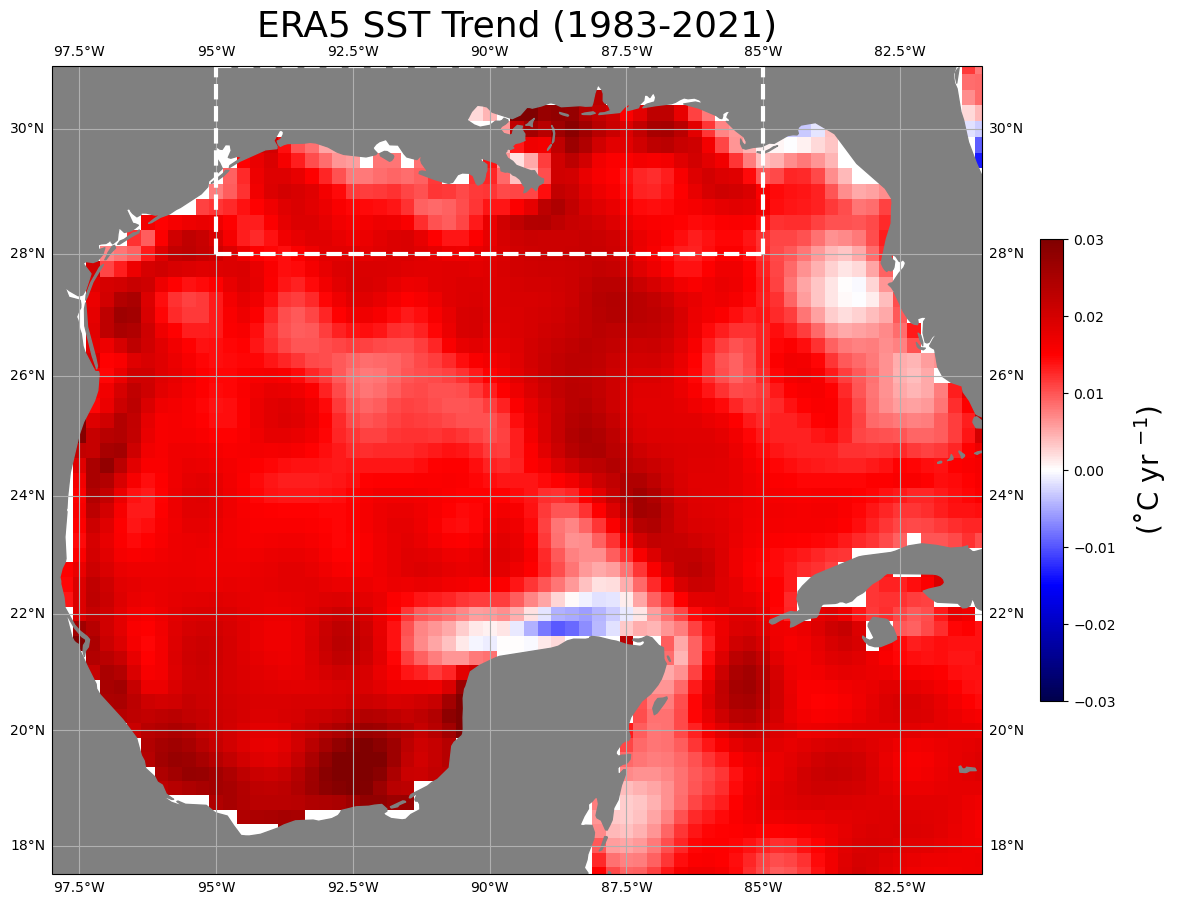

In [17]:
plot_trend(trend_sst_era83, 'ERA5 SST Trend (1983-2021)', 'era_sst83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic')

In [46]:
print('Max: ', trend_sst_era20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_era20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.06638269408283355 C/yr 
Min:  -0.038584074282092706 C/yr


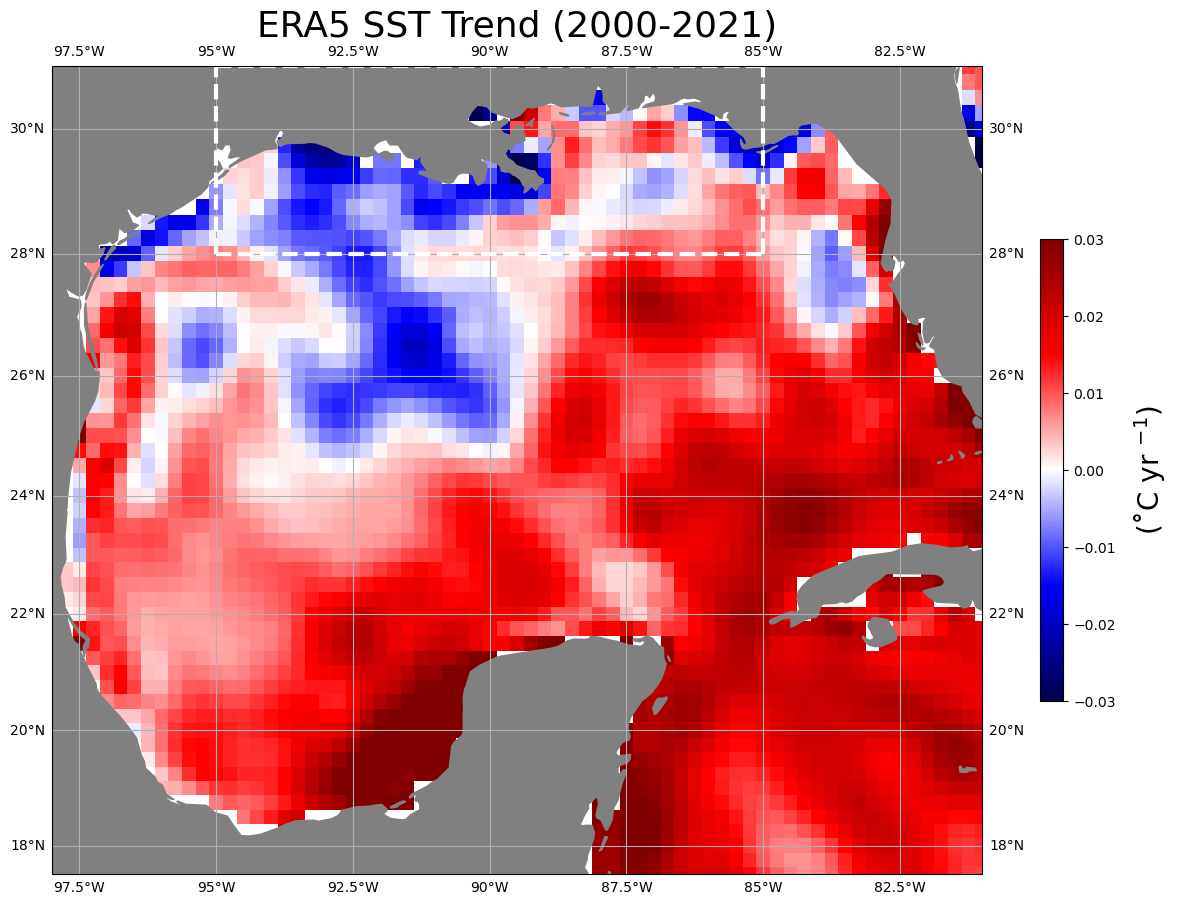

In [18]:
plot_trend(trend_sst_era20, 'ERA5 SST Trend (2000-2021)', 'era_sst83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic')

In [48]:
print('Max: ', trend_sst_esm483.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_esm483.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.015331837426313052 C/yr 
Min:  0.001214766791957526 C/yr


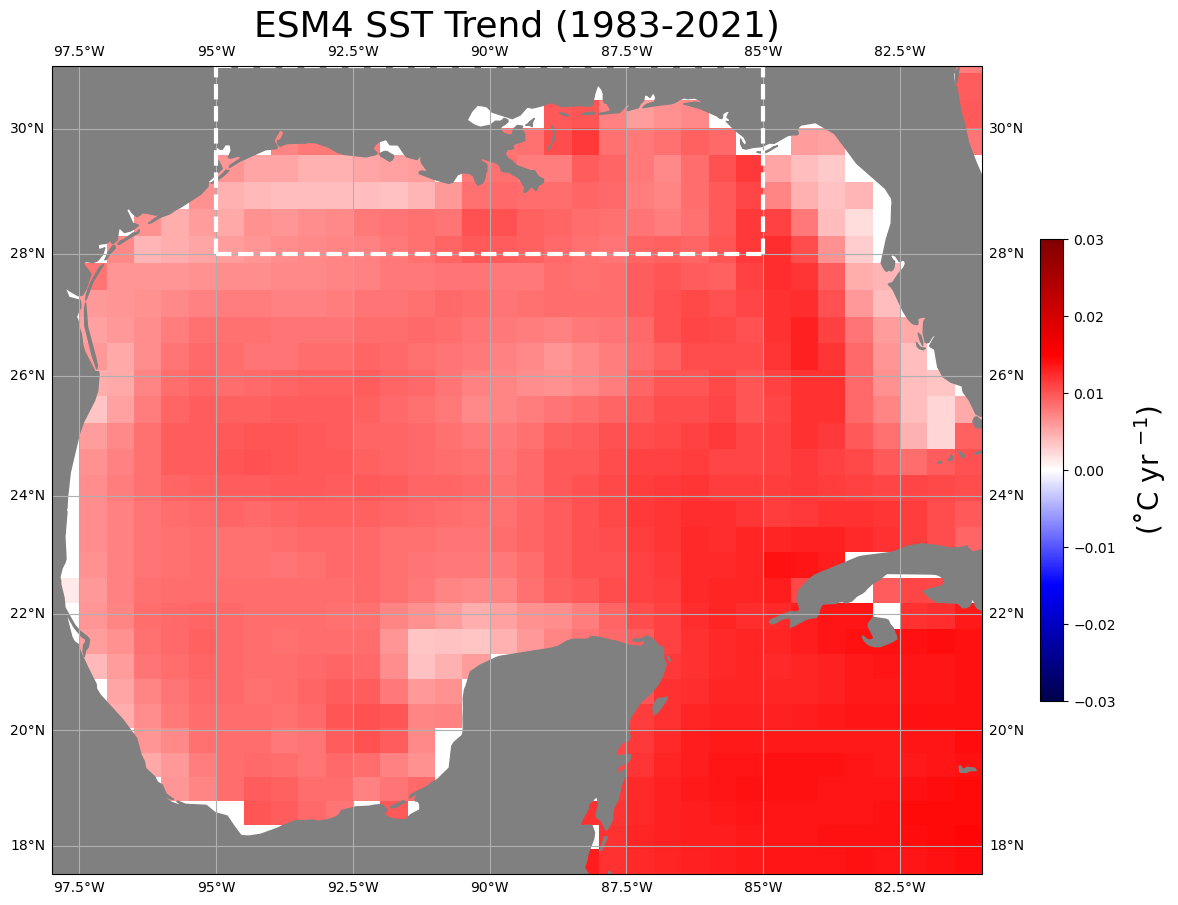

In [21]:
plot_trend(trend_sst_esm483, 'ESM4 SST Trend (1983-2021)', 'esm_sst83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='xh')

In [50]:
print('Max: ', trend_sst_esm420.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_esm420.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.009291919727638324 C/yr 
Min:  -0.05587785894220365 C/yr


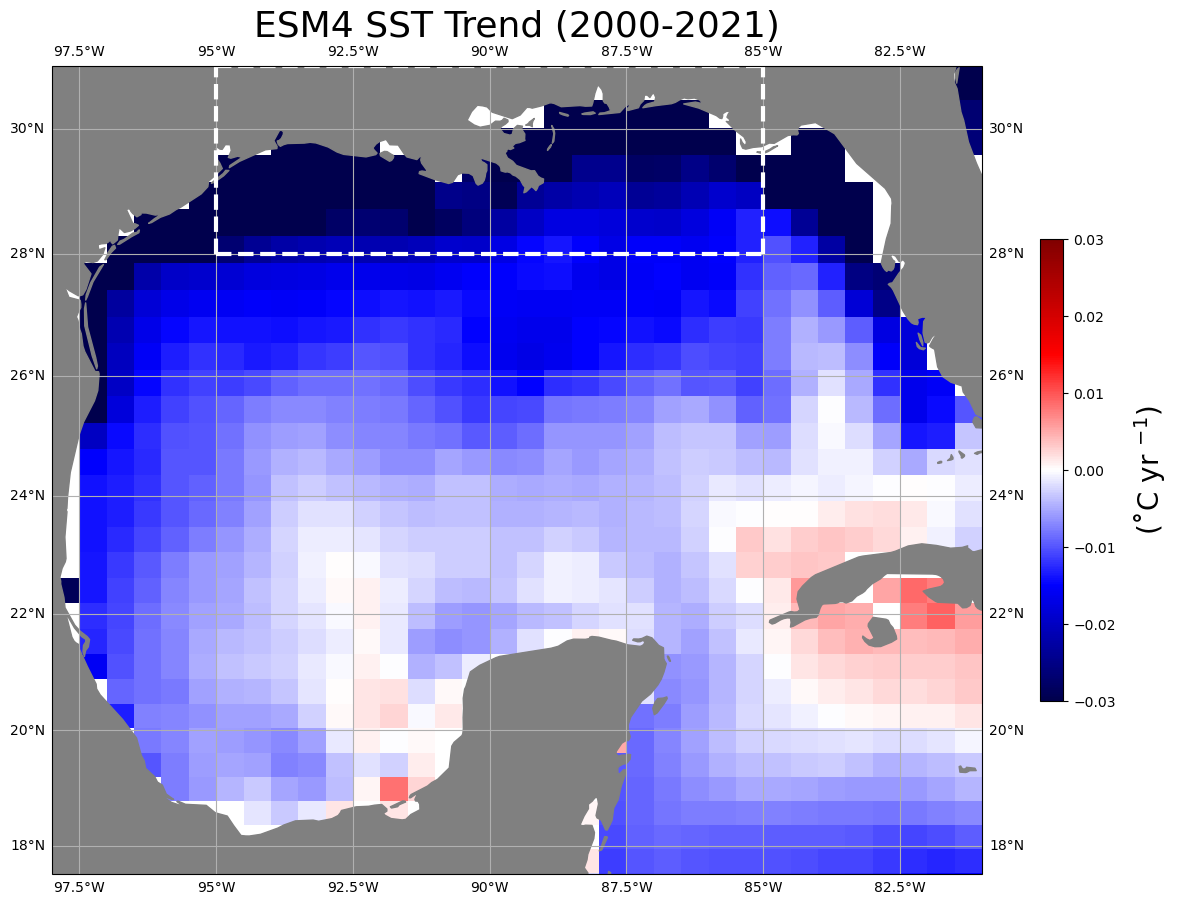

In [22]:
plot_trend(trend_sst_esm420, 'ESM4 SST Trend (2000-2021)', 'esm_sst83', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic', coord_name='xh')

In [52]:
print('Max: ', trend_sst_glorys.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_glorys.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.029032845992137648 C/yr 
Min:  -0.0334678885237912 C/yr


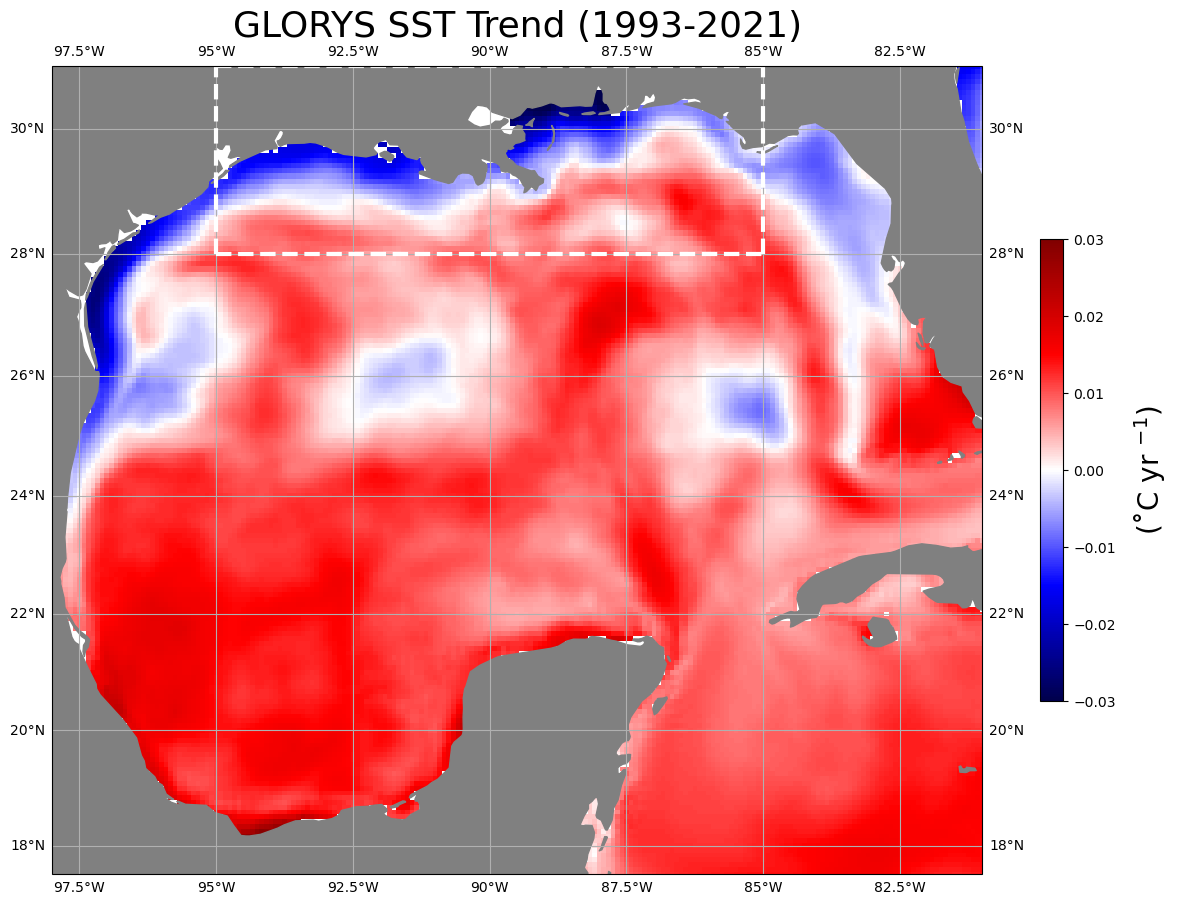

In [53]:
plot_trend(trend_sst_glorys, 'GLORYS SST Trend (1993-2021)', 'glorys_sst93', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic',)

In [54]:
print('Max: ', trend_sst_glorys20.polyfit_coefficients[0].max().values, 'C/yr', 
      '\nMin: ', trend_sst_glorys20.polyfit_coefficients[0].min().values, 'C/yr')

Max:  0.041610587268808466 C/yr 
Min:  -0.05724453985485234 C/yr


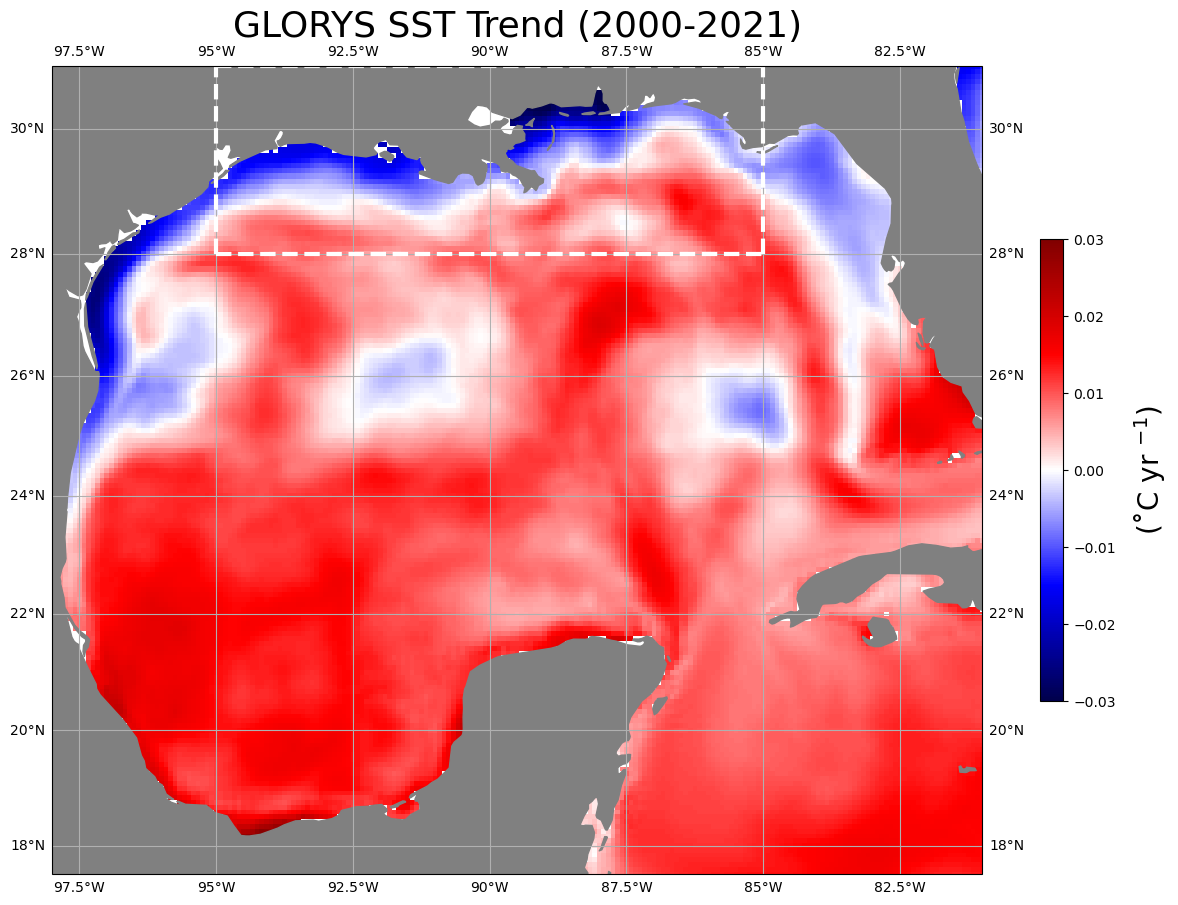

In [23]:
plot_trend(trend_sst_glorys, 'GLORYS SST Trend (2000-2021)', 'glorys_sst20', '(˚C yr $^{-1}$)', 
           -0.03, 0.03, cmap_choice='seismic',)

In [56]:
print('Max: ', trend_sw_era83.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_sw_era83.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.2960450713319657 W/m/yr 
Min:  -0.008037217917836148 W/m/yr


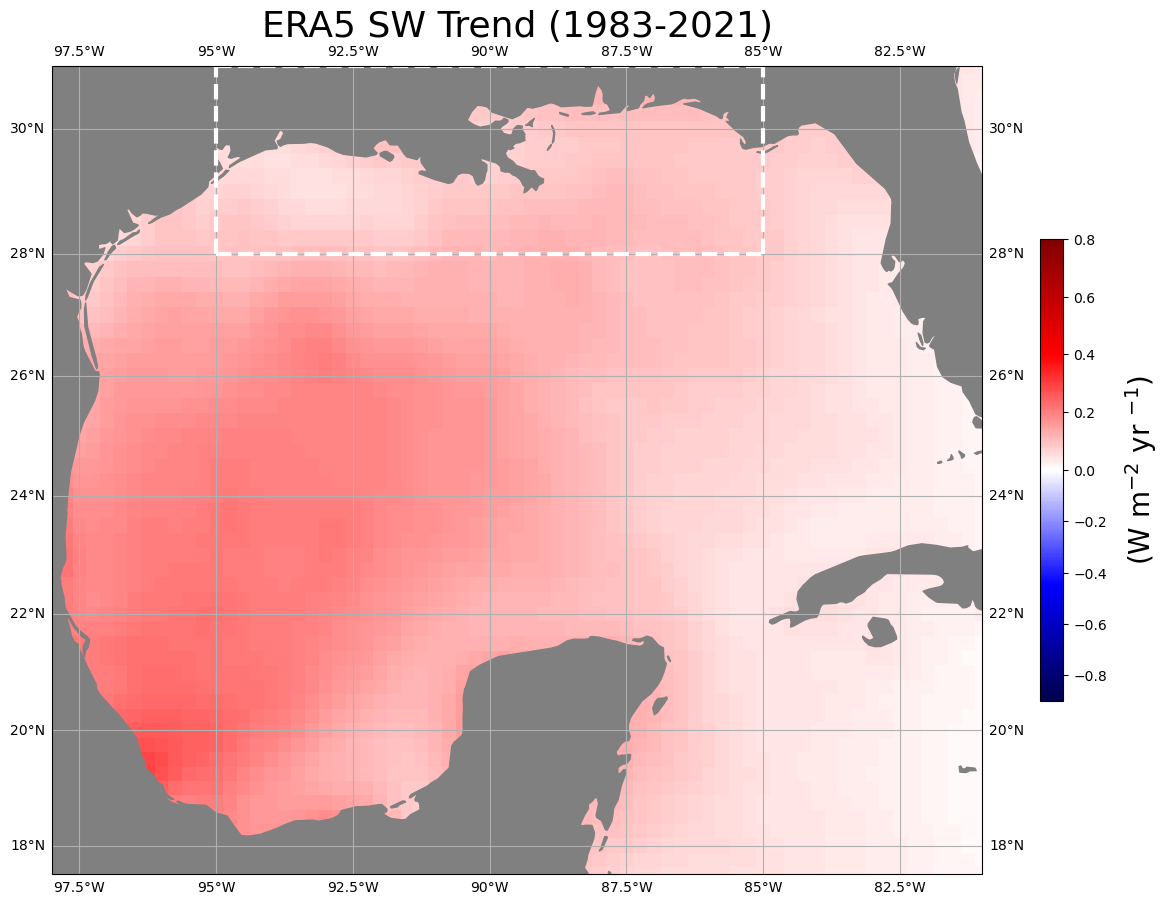

In [24]:
plot_trend(trend_sw_era83, 'ERA5 SW Trend (1983-2021)', 'era_sw83', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic',)

In [58]:
print('Max: ', trend_sw_era20.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_sw_era20.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.31509241894097795 W/m/yr 
Min:  -0.17060275656641974 W/m/yr


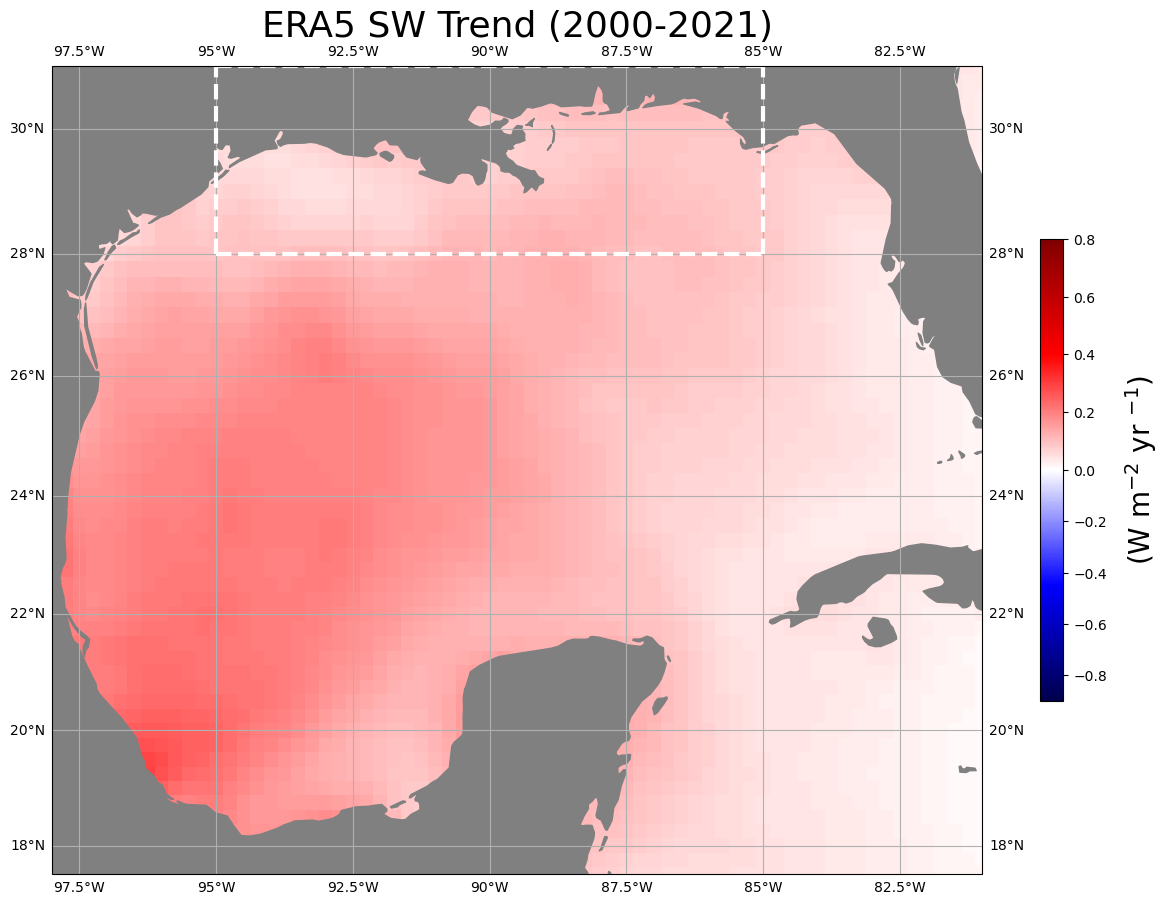

In [27]:
plot_trend(trend_sw_era83, 'ERA5 SW Trend (2000-2021)', 'era_sw20', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic',)

In [60]:
print('Max: ', trend_sw_esm483.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_sw_esm483.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.18319706163908556 W/m/yr 
Min:  -0.07409233680137932 W/m/yr


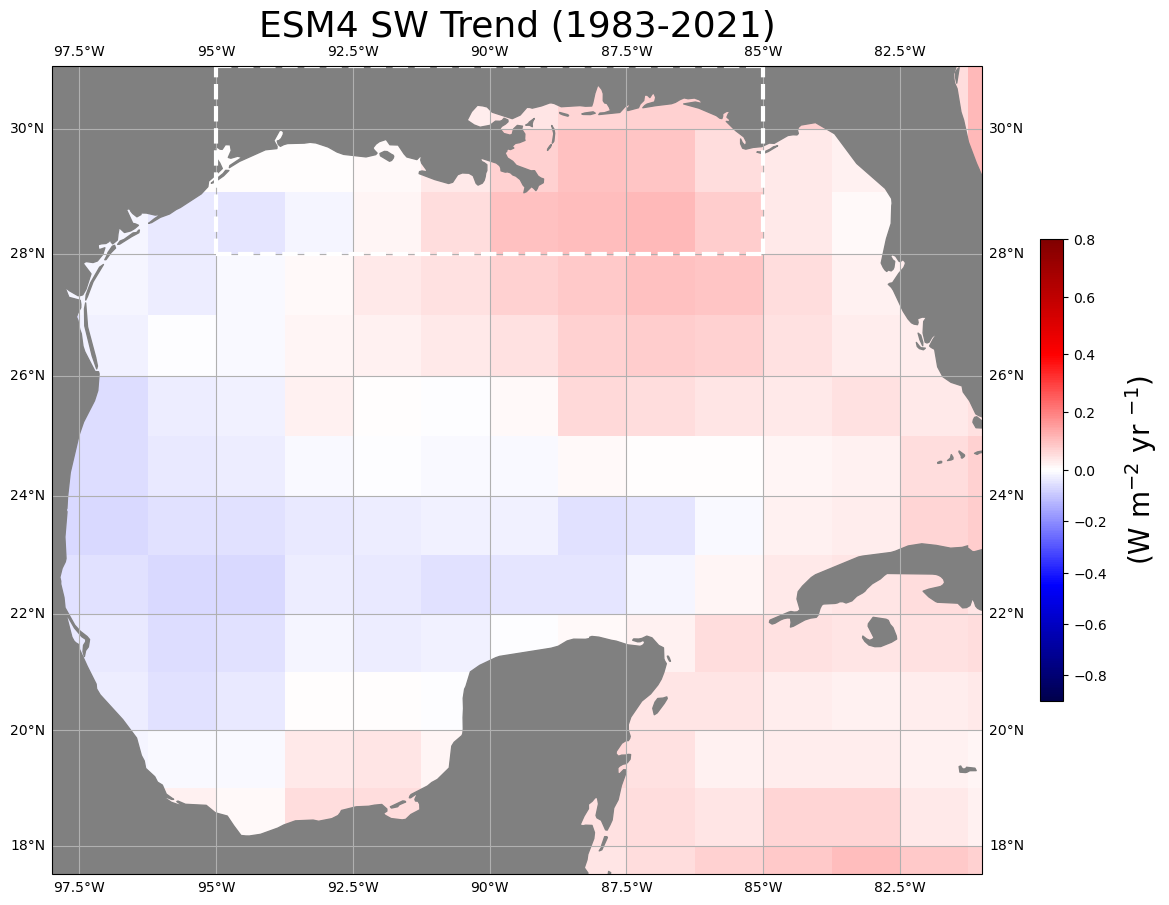

In [28]:
plot_trend(trend_sw_esm483, 'ESM4 SW Trend (1983-2021)', 'esm_sw83', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic', coord_name='lon')

In [62]:
print('Max: ', trend_sw_esm420.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_sw_esm420.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.6695241470379815 W/m/yr 
Min:  -0.1831983311037357 W/m/yr


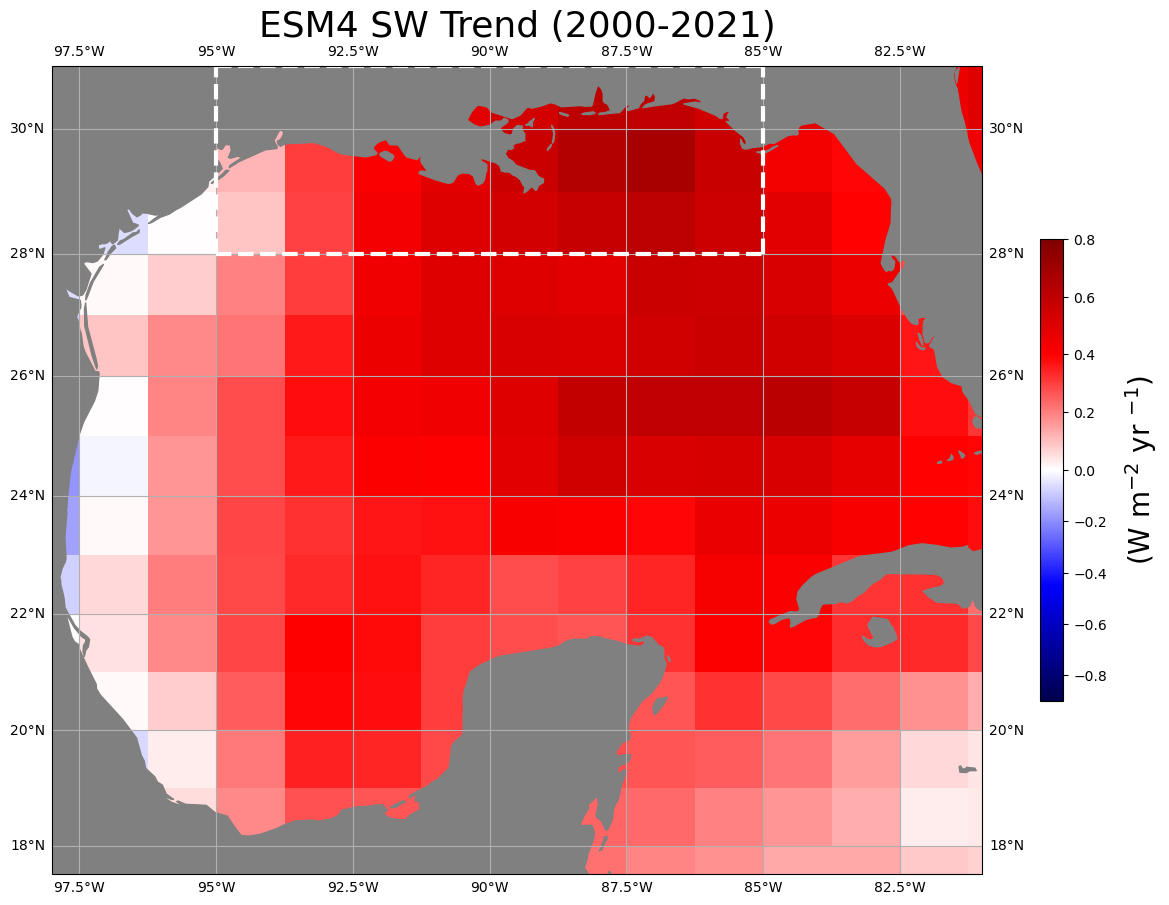

In [29]:
plot_trend(trend_sw_esm420, 'ESM4 SW Trend (2000-2021)', 'esm_sw20', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.9, 0.8, cmap_choice='seismic', coord_name='lon')

In [64]:
print('Max: ', trend_lw_era83.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_lw_era83.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.1051544719626542 W/m/yr 
Min:  -0.1596119482909189 W/m/yr


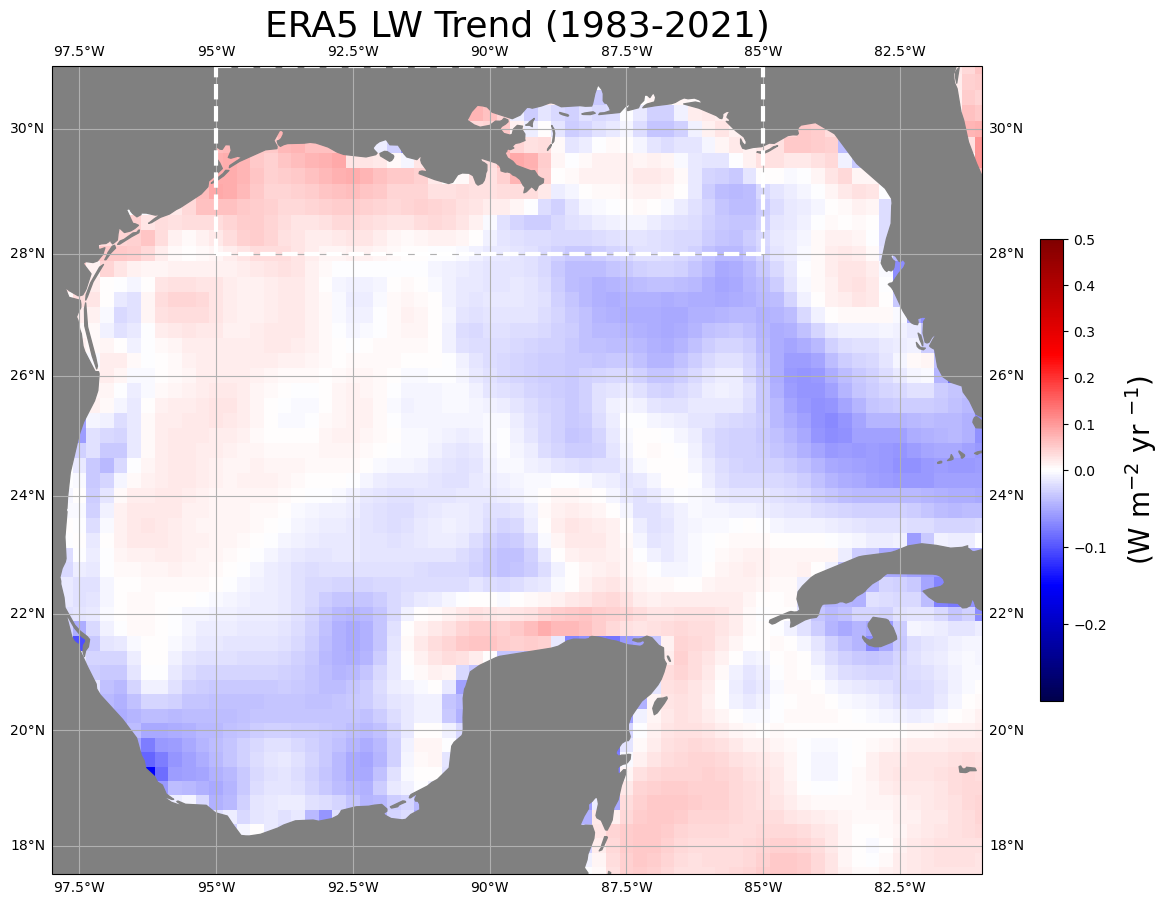

In [30]:
plot_trend(trend_lw_era83, 'ERA5 LW Trend (1983-2021)', 'era_lw83', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic',)

In [66]:
print('Max: ', trend_lw_era20.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_lw_era20.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.48591428883247273 W/m/yr 
Min:  -0.10786066419366523 W/m/yr


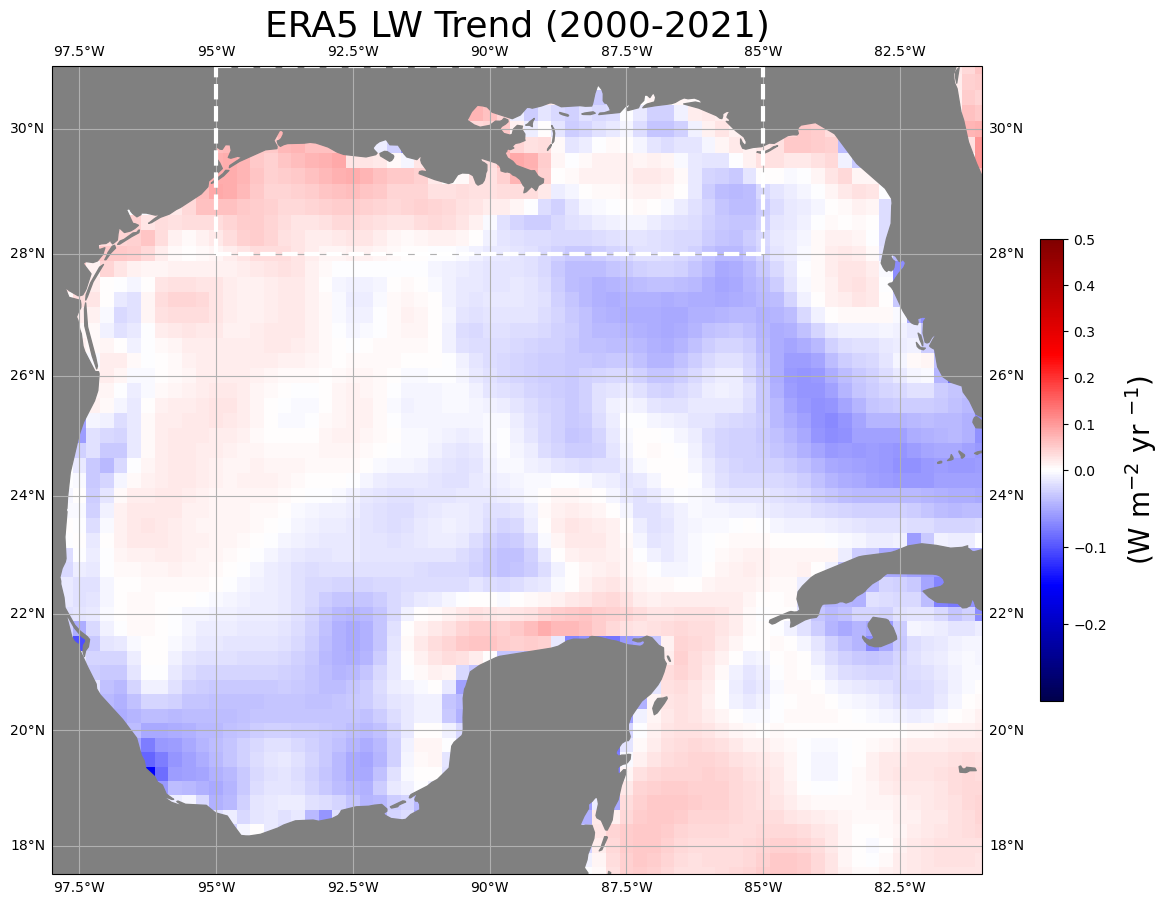

In [31]:
plot_trend(trend_lw_era83, 'ERA5 LW Trend (2000-2021)', 'era_lw20', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic',)

In [68]:
print('Max: ', trend_lw_esm483.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_lw_esm483.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.0994128524533236 W/m/yr 
Min:  -0.08017508163143523 W/m/yr


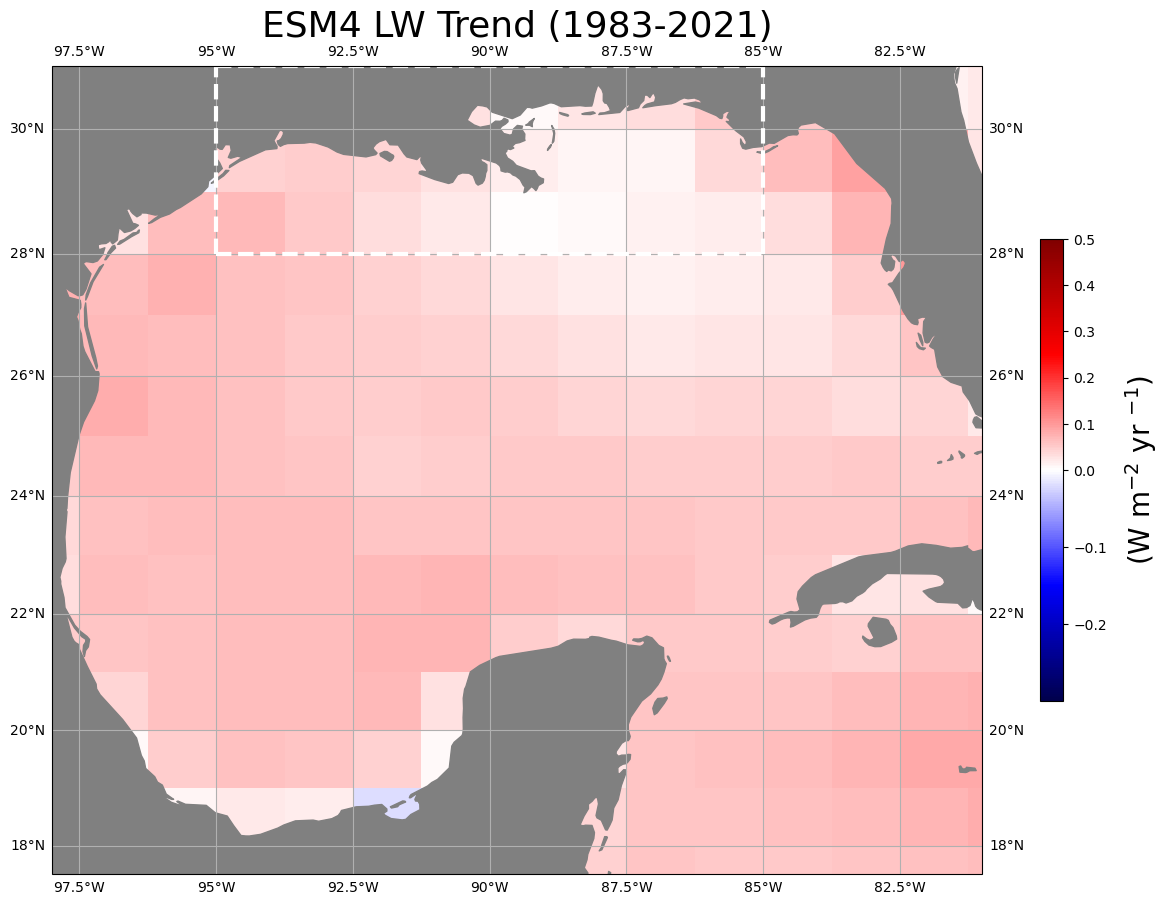

In [32]:
plot_trend(trend_lw_esm483, 'ESM4 LW Trend (1983-2021)', 'esm_lw83', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic', coord_name='lon')

In [70]:
print('Max: ', trend_lw_esm420.polyfit_coefficients[0].max().values, 'W/m/yr', 
      '\nMin: ', trend_lw_esm420.polyfit_coefficients[0].min().values, 'W/m/yr')

Max:  0.2323783581570278 W/m/yr 
Min:  -0.38022221285766844 W/m/yr


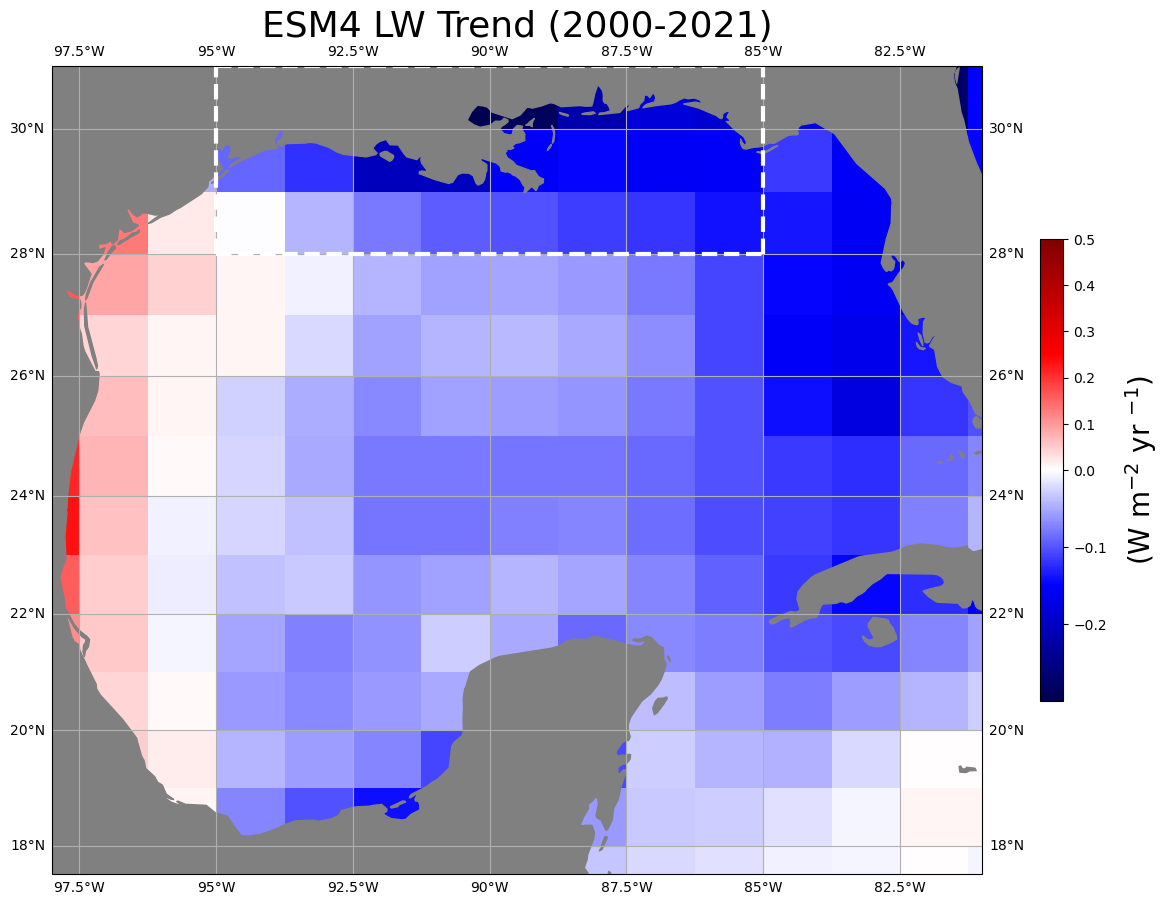

In [33]:
plot_trend(trend_lw_esm420, 'ESM4 LW Trend (2000-2021)', 'esm_lw20', '(W m$^{-2}$ yr $^{-1}$)', 
           -0.3, 0.5, cmap_choice='seismic', coord_name='lon')

# Trends (basin-average)

## Calculate trend lines

In [72]:
def trending_basin(da, da_name, coord_name=None):
    
    d = {}
    
    if coord_name=='lon':
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['lat', 'lon']))
    elif coord_name=='xh':
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['yh', 'xh']))
    else:
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['latitude', 'longitude']))
        
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])

    return d

In [73]:
#obs 
trend_dict_hadisst83 = trending_basin(hadisst83, hadisst83.name)
trend_dict_hadisst20 = trending_basin(hadisst20, hadisst20.name)
trend_dict_pcmdi83 = trending_basin(pcmdi83, pcmdi83.name, coord_name='lon')
trend_dict_pcmdi20 = trending_basin(pcmdi20, pcmdi20.name, coord_name='lon')                   
trend_dict_oisst83 = trending_basin(oisst83, oisst83.name, coord_name='lon')
trend_dict_oisst20 = trending_basin(oisst20, oisst20.name, coord_name='lon')

trend_dict_sw = trending_basin(sw_ceres, 'sw', coord_name='lon')
trend_dict_lw = trending_basin(lw_ceres, 'lw', coord_name='lon')

#reanlyses
trend_dict_sst_era83 = trending_basin(era.sst, era.sst.name)
trend_dict_sst_esm483 = trending_basin(esm4_ocean.tos, esm4_ocean.tos.name, coord_name='xh')
trend_dict_sst_glorys = trending_basin(glorys.thetao, glorys.thetao.name)
trend_dict_sst_era20 = trending_basin(era20.sst, era20.sst.name)
trend_dict_sst_esm420 = trending_basin(esm4_sst20, esm4_sst20.name, coord_name='xh')
trend_dict_sst_glorys20 = trending_basin(glorys20, glorys20.name)

trend_dict_sw_era83 = trending_basin(era.ssr, era.ssr.name)
trend_dict_sw_era20 = trending_basin(era20.ssr, era20.ssr.name)
trend_dict_sw_esm483 = trending_basin(esm4_atm.rss, esm4_atm.rss.name, coord_name='lon')
trend_dict_sw_esm420 = trending_basin(esm4_atm20.rss, esm4_atm20.rss.name, coord_name='lon')
trend_dict_lw_era83 = trending_basin(era.str, era.str.name)
trend_dict_lw_era20 = trending_basin(era20.str, era20.str.name)
trend_dict_lw_esm483 = trending_basin(esm4_atm.rls, esm4_atm.rls.name, coord_name='lon')
trend_dict_lw_esm420 = trending_basin(esm4_atm20.rls, esm4_atm20.rls.name, coord_name='lon')

In [74]:
float(trend_dict_hadisst83['sst_trend_lr'][0])

0.0009730238890910911

In [75]:
trend_dict_hadisst83['sst_trend_lr']

LinregressResult(slope=np.float64(0.0009730238890910911), intercept=np.float64(26.18406989175786), rvalue=np.float64(0.0536722018575801), pvalue=np.float64(0.24959030836850796), stderr=np.float64(0.0008440510897848343), intercept_stderr=np.float64(0.2247731453817273))

In [76]:
trend_dict_hadisst83['sst_trend_lr'][3]

np.float64(0.24959030836850796)

In [77]:
slopes_sst83 = [trend_dict_hadisst83['sst_trend_lr'][0], trend_dict_pcmdi83['tosbcs_trend_lr'][0],
            trend_dict_oisst83['sst_trend_lr'][0], trend_dict_sst_era83['sst_trend_lr'][0],
            trend_dict_sst_esm483['tos_trend_lr'][0], trend_dict_sst_glorys['thetao_trend_lr'][0]]
names = ['hadisst83', 'pcmdi83', 'oisst83', 'era_sst83', 'esm483', 'glorys']
print('Slope (1983-2021)')
for (i,j) in zip(names, slopes_sst83):
    print(i, ':', j)

Slope (1983-2021)
hadisst83 : 0.0009730238890910911
pcmdi83 : 0.0014550062029862147
oisst83 : 0.0017699446424128808
era_sst83 : 5.915458497024832e-05
esm483 : 4.326971413983687e-05
glorys : 4.893266328504842e-05


In [78]:
pvalues83 = [trend_dict_hadisst83['sst_trend_lr'][3], trend_dict_pcmdi83['tosbcs_trend_lr'][3],
            trend_dict_oisst83['sst_trend_lr'][3], trend_dict_sst_era83['sst_trend_lr'][3],
            trend_dict_sst_esm483['tos_trend_lr'][3], trend_dict_sst_glorys['thetao_trend_lr'][3]]
names = ['hadisst83', 'pcmdi83', 'oisst83', 'era_sst83', 'esm483', 'glorys']
print('P Values (1983-2021)')
for (i,j) in zip(names, pvalues83):
    print(i, ':', j)

P Values (1983-2021)
hadisst83 : 0.24959030836850796
pcmdi83 : 0.10425137602199576
oisst83 : 0.02695062393071581
era_sst83 : 2.5751237189575402e-31
esm483 : 7.535786758019086e-18
glorys : 1.1212623986344444e-09


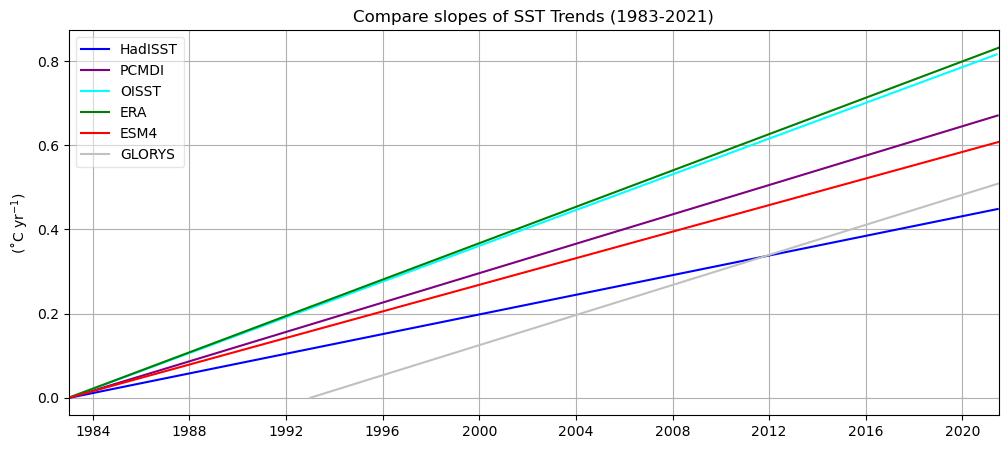

In [79]:
da_names = [hadisst83, pcmdi83, oisst83, era.sst, esm4_ocean.tos, glorys.thetao]
var_titles = ['HadISST', 'PCMDI', 'OISST', 'ERA', 'ESM4', 'GLORYS']
line_colors = ['blue', 'purple', 'cyan', 'green', 'red', 'silver']
plt.figure(figsize=(12,5))
for i in np.arange(0,6):
    plt.plot(da_names[i].time, slopes_sst83[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(˚C yr$^{-1}$)')
plt.xlim(era.time.sel(time='1983-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SST Trends (1983-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/slopes_sst.pdf');

In [80]:
slopes_sst20 = [trend_dict_hadisst20['sst_trend_lr'][0], trend_dict_pcmdi20['tosbcs_trend_lr'][0],
            trend_dict_oisst20['sst_trend_lr'][0], trend_dict_sst_era20['sst_trend_lr'][0],
            trend_dict_sst_esm420['tos_trend_lr'][0], trend_dict_sst_glorys20['thetao_trend_lr'][0]]
names = ['hadisst20', 'pcmdi20', 'oisst20', 'era_sst20', 'esm420', 'glorys20']
print('Slope (2000-2021)')
for (i,j) in zip(names, slopes_sst20):
    print(i, ':', j)

Slope (2000-2021)
hadisst20 : 0.0013932642562889841
pcmdi20 : 0.002444033312938463
oisst20 : 0.002424691231957539
era_sst20 : 7.874120481548143e-05
esm420 : 2.466485721916054e-05
glorys20 : 6.905015716559629e-05


In [81]:
pvalues20 = [trend_dict_hadisst20['sst_trend_lr'][3], trend_dict_pcmdi20['tosbcs_trend_lr'][3],
            trend_dict_oisst20['sst_trend_lr'][3], trend_dict_sst_era20['sst_trend_lr'][3],
            trend_dict_sst_esm420['tos_trend_lr'][3], trend_dict_sst_glorys20['thetao_trend_lr'][3]]
names = ['hadisst20', 'pcmdi20', 'oisst20', 'era_sst20', 'esm420', 'glorys20']
print('P Values (2000-2021)')
for (i,j) in zip(names, pvalues20):
    print(i, ':', j)

P Values (2000-2021)
hadisst20 : 0.5014843408474918
pcmdi20 : 0.26224645571388194
oisst20 : 0.2120223891691014
era_sst20 : 1.0491988324026902e-10
esm420 : 0.04404365701752349
glorys20 : 1.924574784207186e-08


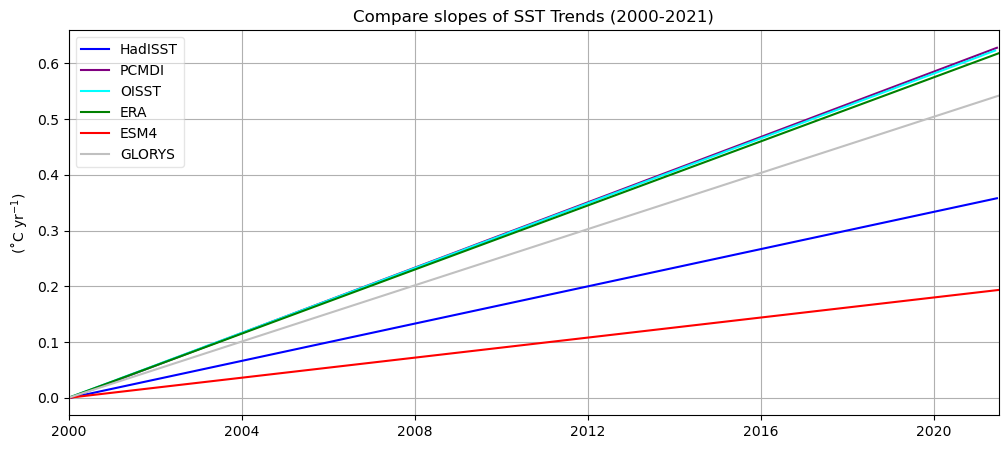

In [82]:
da_names = [hadisst20, pcmdi20, oisst20, era20.sst, esm4_sst20, glorys20]
var_titles = ['HadISST', 'PCMDI', 'OISST', 'ERA', 'ESM4', 'GLORYS']
line_colors = ['blue', 'purple', 'cyan', 'green', 'red', 'silver']
plt.figure(figsize=(12,5))
for i in np.arange(0,6):
    plt.plot(da_names[i].time, slopes_sst20[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(˚C yr$^{-1}$)')
plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SST Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/slopes_sst20.pdf');

In [83]:
slopes_sw = [trend_dict_sw['sw_trend_lr'][0], trend_dict_sw_era20['ssr_trend_lr'][0],
             trend_dict_sw_esm420['rss_trend_lr'][0]]
names = ['ceres', 'era20', 'esm420']
print('SW Slope (2000-2021)')
for (i,j) in zip(names, slopes_sw):
    print(i, ':', j)

SW Slope (2000-2021)
ceres : -0.005069456401420256
era20 : -0.00015503667824012386
esm420 : nan


In [84]:
pvalues = [trend_dict_sw['sw_trend_lr'][3], trend_dict_sw_era20['ssr_trend_lr'][3],
             trend_dict_sw_esm420['rss_trend_lr'][3]]
names = ['ceres', 'era20', 'esm420']
print('SW P Values (2000-2021)')
for (i,j) in zip(names, pvalues):
    print(i, ':', j)

SW P Values (2000-2021)
ceres : 0.8691499054721872
era20 : 0.5461493078973383
esm420 : nan


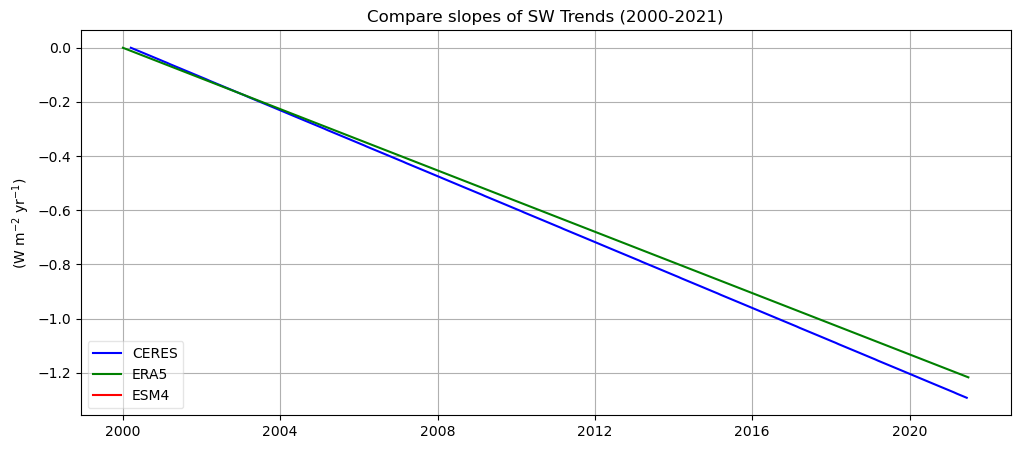

In [85]:
da_names = [sw_ceres, era20.ssr, esm4_atm20.rss,]
var_titles = ['CERES', 'ERA5', 'ESM4']
line_colors = ['blue', 'green', 'red']
plt.figure(figsize=(12,5))
for i in np.arange(0,3):
    plt.plot(da_names[i].time, slopes_sw[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(W m$^{-2}$ yr$^{-1}$)')
#plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
#         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SW Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/slopes_sw.pdf');

In [86]:
slopes_lw = [trend_dict_lw['lw_trend_lr'][0], trend_dict_lw_era20['str_trend_lr'][0],
             trend_dict_lw_esm420['rls_trend_lr'][0]]
names = ['ceres', 'era20', 'esm420']
print('LW Slope (2000-2021)')
for (i,j) in zip(names, slopes_lw):
    print(i, ':', j)

LW Slope (2000-2021)
ceres : 0.009983839904669903
era20 : 0.0006137586678459334
esm420 : nan


In [87]:
pvalues = [trend_dict_lw['lw_trend_lr'][3], trend_dict_lw_era20['str_trend_lr'][3],
             trend_dict_lw_esm420['rls_trend_lr'][3]]
names = ['ceres', 'era20', 'esm420']
print('LW P Values (2000-2021)')
for (i,j) in zip(names, pvalues):
    print(i, ':', j)

LW P Values (2000-2021)
ceres : 0.4616401076047856
era20 : 2.856573007397645e-25
esm420 : nan


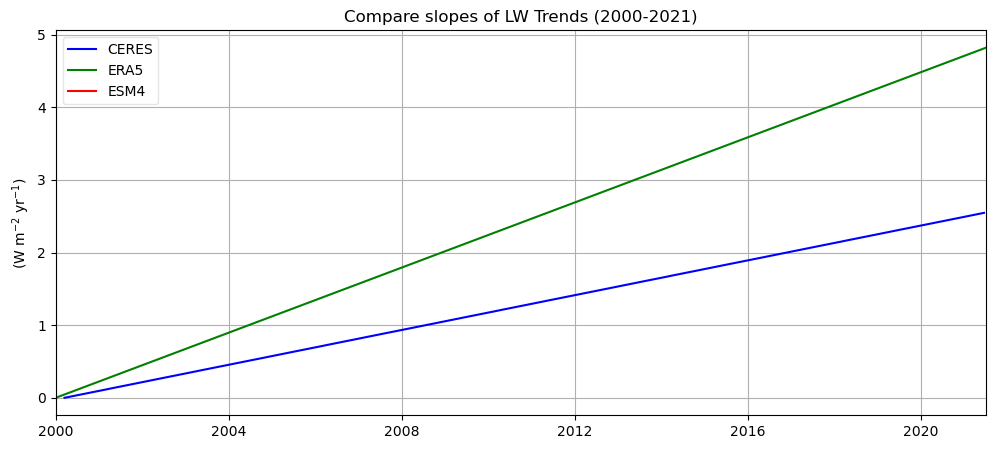

In [88]:
da_names = [lw_ceres, era20.str, esm4_atm20.rls,]
var_titles = ['CERES', 'ERA5', 'ESM4']
line_colors = ['blue', 'green', 'red']
plt.figure(figsize=(12,5))
for i in np.arange(0,3):
    plt.plot(da_names[i].time, slopes_lw[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(W m$^{-2}$ yr$^{-1}$)')
plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of LW Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/slopes_lw.pdf');

__________________________________

# Trends (smaller box-average)

In [89]:
#smaller box coords: n,s,e,w = 31, 28, -85, -95
time_slice83 = dict(time=slice('1983', '2021-06-30'))
time_slice20 = dict(time=slice('2000', '2021-06-30'))

gom_h = dict(latitude=slice(31.5, 28), longitude=slice(-95,-85), )
gom_p = dict(lat=slice(28, 31), lon=slice(264,286))
gom_c = dict(lat=slice(28,31), lon=slice(264,286))
gom_o = dict(lat=slice(28,31.15), lon=slice(264,286))

#hadisst/pcmdi
hadisst83 = hadisst_ds.sst.sel(**gom_h).sel(**time_slice83)
hadisst20 = hadisst_ds.sst.sel(**gom_h).sel(**time_slice20)
pcmdi83 = pcmdi_ds.tosbcs.sel(**gom_p).sel(**time_slice83)
pcmdi20 = pcmdi_ds.tosbcs.sel(**gom_p).sel(**time_slice20)

#ceres
ceres = ceres_ds.sel(**gom_c).sel(**time_slice20)
#sfc_sw_down_all - sfc_sw_up_all = sfc_net_sw_all
sw_ceres = ceres.sfc_net_sw_all_mon - ceres.toa_sw_all_mon
lw_ceres = ceres.sfc_net_lw_all_mon - ceres.toa_lw_all_mon

#oisst  
oisst83 = oisst_ds.sst.sel(**gom_o).sel(**time_slice83)
oisst20 = oisst_ds.sst.sel(**gom_o).sel(**time_slice20)

## Calculate trend lines

In [90]:
def trending_smallbox(da, da_name, coord_name=None):
    
    d = {}
    
    if coord_name=='lon':
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['lat', 'lon']))
    elif coord_name=='xh':
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['yh', 'xh']))
    else:
        d[f'{da_name}_trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['latitude', 'longitude']))
        
    d[f'{da_name}_trend_line_lr'] = (d[f'{da_name}_trend_lr'][0]*np.arange(0,da.time.size) 
                                     + d[f'{da_name}_trend_lr'][1])

    return d

In [91]:
#obs 
trend_dict_hadisst83 = trending_smallbox(hadisst83, hadisst83.name)
trend_dict_hadisst20 = trending_smallbox(hadisst20, hadisst20.name)
trend_dict_pcmdi83 = trending_smallbox(pcmdi83, pcmdi83.name, coord_name='lon')
trend_dict_pcmdi20 = trending_smallbox(pcmdi20, pcmdi20.name, coord_name='lon')                   
trend_dict_oisst83 = trending_smallbox(oisst83, oisst83.name, coord_name='lon')
trend_dict_oisst20 = trending_smallbox(oisst20, oisst20.name, coord_name='lon')

trend_dict_sw = trending_smallbox(sw_ceres, 'sw', coord_name='lon')
trend_dict_lw = trending_smallbox(lw_ceres, 'lw', coord_name='lon')

#reanlyses
trend_dict_sst_era83 = trending_smallbox(era.sst, era.sst.name)
trend_dict_sst_esm483 = trending_smallbox(esm4_ocean.tos, esm4_ocean.tos.name, coord_name='xh')
trend_dict_sst_glorys = trending_smallbox(glorys.thetao, glorys.thetao.name)
trend_dict_sst_era20 = trending_smallbox(era20.sst, era20.sst.name)
trend_dict_sst_esm420 = trending_smallbox(esm4_sst20, esm4_sst20.name, coord_name='xh')
trend_dict_sst_glorys20 = trending_smallbox(glorys20, glorys20.name)

trend_dict_sw_era83 = trending_smallbox(era.ssr, era.ssr.name)
trend_dict_sw_era20 = trending_smallbox(era20.ssr, era20.ssr.name)
trend_dict_sw_esm483 = trending_smallbox(esm4_atm.rss, esm4_atm.rss.name, coord_name='lon')
trend_dict_sw_esm420 = trending_smallbox(esm4_atm20.rss, esm4_atm20.rss.name, coord_name='lon')
trend_dict_lw_era83 = trending_smallbox(era.str, era.str.name)
trend_dict_lw_era20 = trending_smallbox(era20.str, era20.str.name)
trend_dict_lw_esm483 = trending_smallbox(esm4_atm.rls, esm4_atm.rls.name, coord_name='lon')
trend_dict_lw_esm420 = trending_smallbox(esm4_atm20.rls, esm4_atm20.rls.name, coord_name='lon')

In [92]:
float(trend_dict_hadisst83['sst_trend_lr'][0])

0.0009845649161356678

In [93]:
trend_dict_hadisst83['sst_trend_lr']

LinregressResult(slope=np.float64(0.0009845649161356678), intercept=np.float64(24.323346940883464), rvalue=np.float64(0.03189530797410498), pvalue=np.float64(0.4940506425469098), stderr=np.float64(0.0014385256883424852), intercept_stderr=np.float64(0.38308337918689395))

In [94]:
trend_dict_hadisst83['sst_trend_lr'][3]

np.float64(0.4940506425469098)

In [95]:
slopes_sst83 = [trend_dict_hadisst83['sst_trend_lr'][0], trend_dict_pcmdi83['tosbcs_trend_lr'][0],
            trend_dict_oisst83['sst_trend_lr'][0], trend_dict_sst_era83['sst_trend_lr'][0],
            trend_dict_sst_esm483['tos_trend_lr'][0], trend_dict_sst_glorys['thetao_trend_lr'][0]]
names = ['hadisst83', 'pcmdi83', 'oisst83', 'era_sst83', 'esm483', 'glorys']
print('Slope (1983-2021)')
for (i,j) in zip(names, slopes_sst83):
    print(i, ':', j)

Slope (1983-2021)
hadisst83 : 0.0009845649161356678
pcmdi83 : 0.0009499509842948248
oisst83 : 0.0016011951814304442
era_sst83 : 5.915458497024832e-05
esm483 : 4.326971413983687e-05
glorys : 4.893266328504842e-05


In [96]:
pvalues83 = [trend_dict_hadisst83['sst_trend_lr'][3], trend_dict_pcmdi83['tosbcs_trend_lr'][3],
            trend_dict_oisst83['sst_trend_lr'][3], trend_dict_sst_era83['sst_trend_lr'][3],
            trend_dict_sst_esm483['tos_trend_lr'][3], trend_dict_sst_glorys['thetao_trend_lr'][3]]
names = ['hadisst83', 'pcmdi83', 'oisst83', 'era_sst83', 'esm483', 'glorys']
print('P Values (1983-2021)')
for (i,j) in zip(names, pvalues83):
    print(i, ':', j)

P Values (1983-2021)
hadisst83 : 0.4940506425469098
pcmdi83 : 0.46998299202777927
oisst83 : 0.15830131007243806
era_sst83 : 2.5751237189575402e-31
esm483 : 7.535786758019086e-18
glorys : 1.1212623986344444e-09


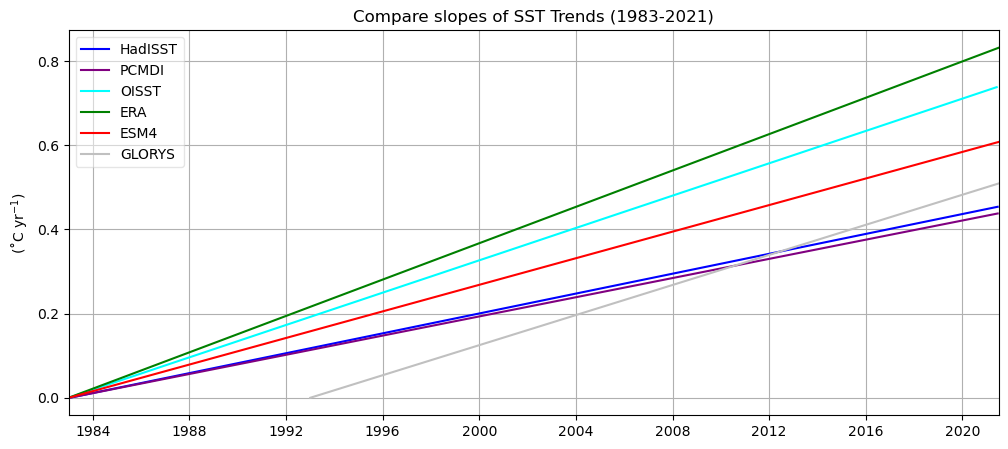

In [97]:
da_names = [hadisst83, pcmdi83, oisst83, era.sst, esm4_ocean.tos, glorys.thetao]
var_titles = ['HadISST', 'PCMDI', 'OISST', 'ERA', 'ESM4', 'GLORYS']
line_colors = ['blue', 'purple', 'cyan', 'green', 'red', 'silver']
plt.figure(figsize=(12,5))
for i in np.arange(0,6):
    plt.plot(da_names[i].time, slopes_sst83[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(˚C yr$^{-1}$)')
plt.xlim(era.time.sel(time='1983-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SST Trends (1983-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/sb_slopes_sst.pdf');

In [98]:
slopes_sst20 = [trend_dict_hadisst20['sst_trend_lr'][0], trend_dict_pcmdi20['tosbcs_trend_lr'][0],
            trend_dict_oisst20['sst_trend_lr'][0], trend_dict_sst_era20['sst_trend_lr'][0],
            trend_dict_sst_esm420['tos_trend_lr'][0], trend_dict_sst_glorys20['thetao_trend_lr'][0]]
names = ['hadisst20', 'pcmdi20', 'oisst20', 'era_sst20', 'esm420', 'glorys20']
print('Slope (2000-2021)')
for (i,j) in zip(names, slopes_sst20):
    print(i, ':', j)

Slope (2000-2021)
hadisst20 : 0.00027741617512781606
pcmdi20 : 0.0022756886476932607
oisst20 : 0.0025779032971613067
era_sst20 : 7.874120481548143e-05
esm420 : 2.466485721916054e-05
glorys20 : 6.905015716559629e-05


In [99]:
pvalues20 = [trend_dict_hadisst20['sst_trend_lr'][3], trend_dict_pcmdi20['tosbcs_trend_lr'][3],
            trend_dict_oisst20['sst_trend_lr'][3], trend_dict_sst_era20['sst_trend_lr'][3],
            trend_dict_sst_esm420['tos_trend_lr'][3], trend_dict_sst_glorys20['thetao_trend_lr'][3]]
names = ['hadisst20', 'pcmdi20', 'oisst20', 'era_sst20', 'esm420', 'glorys20']
print('P Values (2000-2021)')
for (i,j) in zip(names, pvalues20):
    print(i, ':', j)

P Values (2000-2021)
hadisst20 : 0.9370445629558241
pcmdi20 : 0.4789427815975257
oisst20 : 0.3510789647132899
era_sst20 : 1.0491988324026902e-10
esm420 : 0.04404365701752349
glorys20 : 1.924574784207186e-08


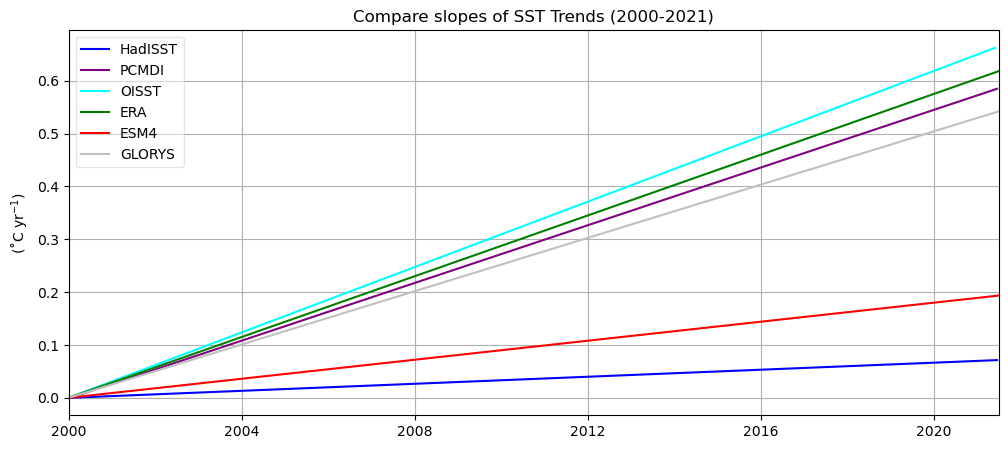

In [100]:
da_names = [hadisst20, pcmdi20, oisst20, era20.sst, esm4_sst20, glorys20]
var_titles = ['HadISST', 'PCMDI', 'OISST', 'ERA', 'ESM4', 'GLORYS']
line_colors = ['blue', 'purple', 'cyan', 'green', 'red', 'silver']
plt.figure(figsize=(12,5))
for i in np.arange(0,6):
    plt.plot(da_names[i].time, slopes_sst20[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(˚C yr$^{-1}$)')
plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SST Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/sb_slopes_sst20.pdf');

In [101]:
slopes_sw = [trend_dict_sw['sw_trend_lr'][0], trend_dict_sw_era20['ssr_trend_lr'][0],
             trend_dict_sw_esm420['rss_trend_lr'][0]]
names = ['ceres', 'era20', 'esm420']
print('SW Slope (2000-2021)')
for (i,j) in zip(names, slopes_sw):
    print(i, ':', j)

SW Slope (2000-2021)
ceres : -0.015838117205445555
era20 : -0.00015503667824012386
esm420 : nan


In [102]:
pvalues = [trend_dict_sw['sw_trend_lr'][3], trend_dict_sw_era20['ssr_trend_lr'][3],
             trend_dict_sw_esm420['rss_trend_lr'][3]]
names = ['ceres', 'era20', 'esm420']
print('SW P Values (2000-2021)')
for (i,j) in zip(names, pvalues):
    print(i, ':', j)

SW P Values (2000-2021)
ceres : 0.6500794243686426
era20 : 0.5461493078973383
esm420 : nan


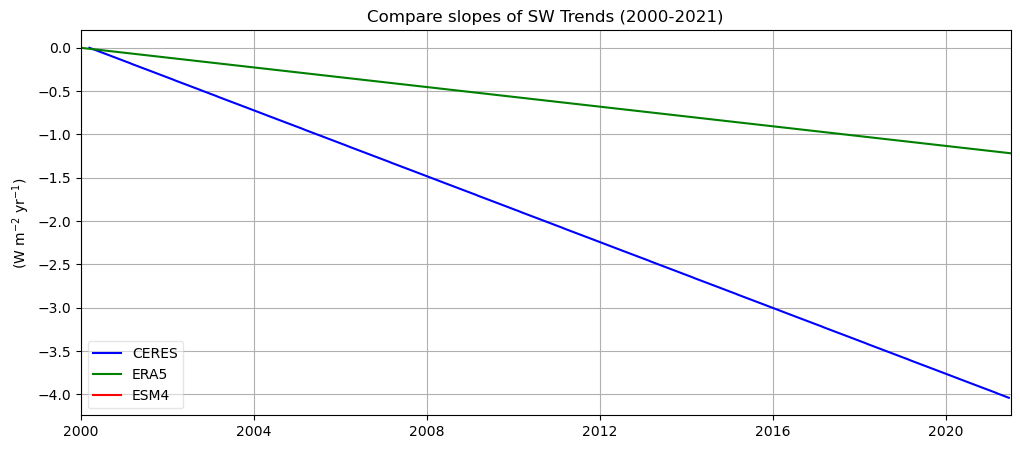

In [103]:
da_names = [sw_ceres, era20.ssr, esm4_atm20.rss,]
var_titles = ['CERES', 'ERA5', 'ESM4']
line_colors = ['blue', 'green', 'red']
plt.figure(figsize=(12,5))
for i in np.arange(0,3):
    plt.plot(da_names[i].time, slopes_sw[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(W m$^{-2}$ yr$^{-1}$)')
plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of SW Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/sb_slopes_sw.pdf');

In [104]:
slopes_lw = [trend_dict_lw['lw_trend_lr'][0], trend_dict_lw_era20['str_trend_lr'][0],
             trend_dict_lw_esm420['rls_trend_lr'][0]]
names = ['ceres', 'era20', 'esm420']
print('LW Slope (2000-2021)')
for (i,j) in zip(names, slopes_lw):
    print(i, ':', j)

LW Slope (2000-2021)
ceres : 0.021796666667237112
era20 : 0.0006137586678459334
esm420 : nan


In [105]:
pvalues = [trend_dict_lw['lw_trend_lr'][3], trend_dict_lw_era20['str_trend_lr'][3],
             trend_dict_lw_esm420['rls_trend_lr'][3]]
names = ['ceres', 'era20', 'esm420']
print('LW P Values (2000-2021)')
for (i,j) in zip(names, pvalues):
    print(i, ':', j)

LW P Values (2000-2021)
ceres : 0.11108294263880186
era20 : 2.856573007397645e-25
esm420 : nan


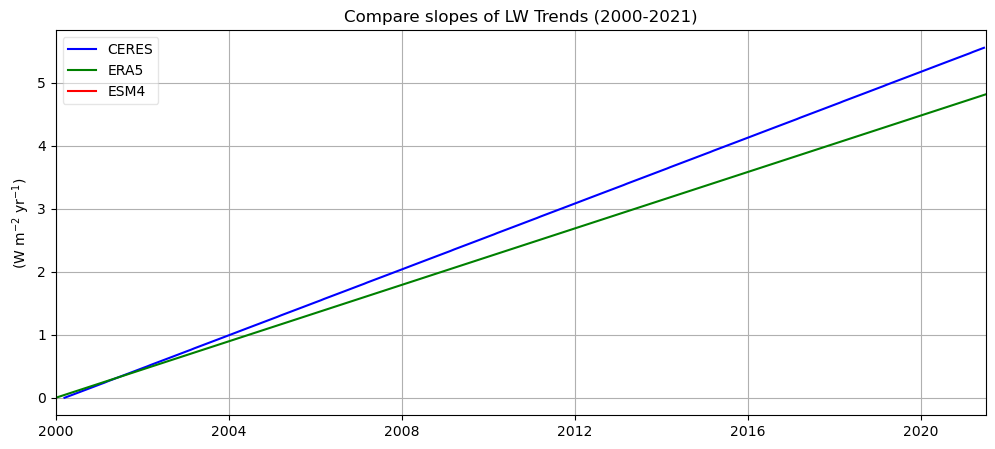

In [106]:
da_names = [lw_ceres, era20.str, esm4_atm20.rls,]
var_titles = ['CERES', 'ERA5', 'ESM4']
line_colors = ['blue', 'green', 'red']
plt.figure(figsize=(12,5))
for i in np.arange(0,3):
    plt.plot(da_names[i].time, slopes_lw[i]*np.arange(0,len(da_names[i].time)), 
             label=f'{var_titles[i]}', color=line_colors[i])
plt.ylabel(r'(W m$^{-2}$ yr$^{-1}$)')
plt.xlim(era.time.sel(time='2000-01-01', method='nearest'), 
         era.time.sel(time='2021-06-30', method='nearest'))
plt.legend()
plt.legend(loc='upper left', framealpha=0.5)
plt.grid()
plt.title('Compare slopes of LW Trends (2000-2021)');
plt.savefig('/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/trend_basin-avg/sb_slopes_lw.pdf');

__________________________________

__________________________________

__________________________________

# EOFS

In [6]:
def xeof_func(da):
    # this sets up the solver
    da_anom = da.groupby('time.day') - da.groupby('time.day').mean('time')
    eof = xeofs.single.EOF(n_modes=3)
    eofs = eof.fit(da_anom, dim='time')
    
    comps = eof.components()  # EOFs (spatial patterns)
    scores = eof.scores()  # PCs (temporal patterns)
    variance = eof.explained_variance_ratio() #variance ratio
    
    return comps, scores, variance

In [7]:
#1983-2021 - except glorys
comp_era_sst, scores_era_sst, vari_era_sst = xeof_func(era.sst)
comp_era_ssr, scores_era_ssr, vari_era_ssr = xeof_func(era.ssr)
comp_era_str, scores_era_str, vari_era_str = xeof_func(era.str)
comp_glorys_sst, scores_glorys_sst, vari_glorys_sst = xeof_func(glorys.thetao)
comp_esm4_sst, scores_esm4_sst, vari_esm4_sst = xeof_func(esm4_ocean.tos)
comp_esm4_rss, scores_esm4_rss, vari_esm4_rss = xeof_func(esm4_atm.rss)
comp_esm4_rls, scores_esm4_rls, vari_esm4_rls = xeof_func(esm4_atm.rls)
comp_hadisst, scores_hadisst, vari_hadisst = xeof_func(hadisst83)
comp_pcmdi, scores_pcmdi, vari_pcmdi = xeof_func(pcmdi83)
comp_oisst, scores_oisst, vari_oisst = xeof_func(oisst83)

#2000-2021
comp_era20_sst, scores_era20_sst, vari_era20_sst = xeof_func(era20.sst)
comp_era20_ssr, scores_era20_ssr, vari_era20_ssr = xeof_func(era20.ssr)
comp_era20_str, scores_era20_str, vari_era20_str = xeof_func(era20.str)
comp_glorys20_sst, scores_glorys20_sst, vari_glorys20_sst = xeof_func(glorys20)
comp_esm420_sst, scores_esm420_sst, vari_esm420_sst = xeof_func(esm4_sst20)
comp_esm420_rss, scores_esm420_rss, vari_esm420_rss = xeof_func(esm4_atm20.rss)
comp_esm420_rls, scores_esm420_rls, vari_esm420_rls = xeof_func(esm4_atm20.rls)
comp_hadisst20, scores_hadisst20, vari_hadisst20 = xeof_func(hadisst20)
comp_pcmdi20, scores_pcmdi20, vari_pcmdi20 = xeof_func(pcmdi20)
comp_oisst20, scores_oisst20, vari_oisst20 = xeof_func(oisst20)
comp_ceres_sw, scores_ceres_sw, vari_ceres_sw, = xeof_func(sw_ceres)
comp_ceres_lw, scores_ceres_lw, vari_ceres_lw, = xeof_func(lw_ceres)

KeyboardInterrupt: 

In [ ]:
def plot_eofs(da_components, da_variance, da_scores, suptitle, var_name):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    figA, ax = plt.subplots(1,3, figsize=(18,5), subplot_kw=dict(projection=proj))
    figB, bx = plt.subplots(1,3, figsize=(15,4), gridspec_kw={'width_ratios': [0.5, 0.5, 0.5]})

    ax[0].set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='0.5'))
    ax[1].set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='0.5'))
    ax[2].set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax[2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='0.5'))
    
    n,s,e,w = 31, 28, -85, -95
    
    da_components[0].plot.contourf(ax=ax[0], cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), 
                                   cbar_kwargs={'shrink':0.8, 'label':''})
    ax[0].set_title(f'{da_variance[0].values*100:.2f} %')
    ax[0].plot([w, e], [s, s], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[0].plot([w, e], [n, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[0].plot([w, w], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[0].plot([e, e], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    da_scores[0].plot(ax=bx[0])
    bx[0].set_ylabel('')
    bx[0].grid()
    
    da_components[1].plot.contourf(ax=ax[1], cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), 
                                   cbar_kwargs={'shrink':0.8, 'label':''})
    ax[1].set_title(f'{da_variance[1].values*100:.2f} %')
    ax[1].plot([w, e], [s, s], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[1].plot([w, e], [n, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[1].plot([w, w], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[1].plot([e, e], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    da_scores[1].plot(ax=bx[1])
    bx[1].set_ylabel('')
    bx[1].grid()
    
    da_components[2].plot.contourf(ax=ax[2], cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), 
                                   cbar_kwargs={'shrink':0.8, 'label':''})
    ax[2].set_title(f'{da_variance[2].values*100:.2f} %')
    ax[2].plot([w, e], [s, s], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[2].plot([w, e], [n, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[2].plot([w, w], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    ax[2].plot([e, e], [s, n], color='w', linestyle='--', linewidth=3, transform=ccrs.PlateCarree())
    da_scores[2].plot(ax=bx[2])
    bx[2].set_ylabel('')
    bx[2].grid()
    
    figA.suptitle(f'{suptitle}', fontweight='bold', fontsize=16, y=1.02)
    figA.tight_layout()
    figB.tight_layout()
    figA.savefig(f'/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/eofs/eof_{var_name}.pdf')
    figB.savefig(f'/work5/stb/MHW-gfdl/paper-figs/09-comparison-figs/eofs/pcs_{var_name}.pdf');

### 1983-2021

In [ ]:
plot_eofs(comp_hadisst, vari_hadisst, scores_hadisst, 'HadISST (1983-2021)', 'hadisst83')

In [ ]:
plot_eofs(comp_pcmdi, vari_pcmdi, scores_pcmdi, 'PCMDI (1983-2021)', 'pcmdi83')

In [ ]:
plot_eofs(comp_oisst, vari_oisst, scores_oisst, 'OISST (1983-2021)', 'oisst83')

In [ ]:
plot_eofs(comp_era_sst, vari_era_sst, scores_era_sst, 'ERA SST (1983-2021)', 'era5_sst83')

In [ ]:
plot_eofs(comp_glorys_sst, vari_glorys_sst, scores_glorys_sst, 'GLORYS SST (1993-2021)', 'glorys83')

In [ ]:
plot_eofs(comp_esm4_sst, vari_esm4_sst, scores_esm4_sst, 'ESM4 SST (1983-2021)', 'esm4_sst83')

In [ ]:
plot_eofs(comp_era_str, vari_era_str, scores_era_str, 'ERA LW (1983-2021)', 'era5_lw83')

In [ ]:
plot_eofs(comp_era_ssr, vari_era_ssr, scores_era_ssr, 'ERA SW (1983-2021)', 'era5_sw83')

In [ ]:
plot_eofs(comp_esm4_rls, vari_esm4_rls, scores_esm4_rls, 'ESM4 LW (1983-2021)', 'esm4_lw83')

In [ ]:
plot_eofs(comp_esm4_rss, vari_esm4_rss, scores_esm4_rss, 'ESM4 SW (1983-2021)', 'esm4_sw83')

### 2000-2021

In [ ]:
plot_eofs(comp_hadisst20, vari_hadisst20, scores_hadisst20, 'HadISST (2000-2021)', 'hadisst20')

In [ ]:
plot_eofs(comp_pcmdi20, vari_pcmdi20, scores_pcmdi20, 'PCMDI (2000-2021)', 'pcmdi20')

In [ ]:
plot_eofs(comp_oisst20, vari_oisst20, scores_oisst20, 'OISST (2000-2021)', 'oisst20')

In [ ]:
plot_eofs(comp_era20_sst, vari_era20_sst, scores_era20_sst, 'ERA SST (2000-2021)', 'era5_sst20')

In [ ]:
plot_eofs(comp_glorys20_sst, vari_glorys20_sst, scores_glorys20_sst, 'GLORYS SST (2000-2021)', 'glorys20')

In [ ]:
plot_eofs(comp_esm420_sst, vari_esm420_sst, scores_esm420_sst, 'ESM4 SST (2000-2021)', 'esm4_sst20')

In [ ]:
plot_eofs(comp_ceres_lw, vari_ceres_lw, scores_ceres_lw, 'CERES LW (2000-2021)', 'ceres_lw')

In [ ]:
plot_eofs(comp_esm420_rls, vari_esm420_rls, scores_esm420_rls, 'ESM4 LW (2000-2021)', 'esm4_lw20')

In [ ]:
plot_eofs(comp_era20_str, vari_era20_str, scores_era20_str, 'ERA LW (2000-2021)', 'era5_lw20')

In [ ]:
plot_eofs(comp_ceres_sw, vari_ceres_sw, scores_ceres_sw, 'CERES SW (2000-2021)', 'ceres_sw')

In [ ]:
plot_eofs(comp_esm420_rss, vari_esm420_rss, scores_esm420_rss, 'ESM4 SW (2000-2021)', 'esm4_sw20')

In [ ]:
plot_eofs(comp_era20_ssr, vari_era20_ssr, scores_era20_ssr, 'ERA SW (2000-2021)', 'era5_sw20')

## Regrid data onto HadISST

In [45]:
def regrid(da_in, da_out):
    regridder_da_in = xe.Regridder(da_in, da_out, method='bilinear')
    da_in_new_grid = regridder_da_in(da_in)

    return da_in_new_grid

In [46]:
era_ngh = regrid(era, hadisst83)
glorys_ngh = regrid(glorys, hadisst83.sel(time=slice('1993', None)))
esm_sst_ngh = regrid(esm4_ocean.tos, hadisst83)
esm_atm_ngh = regrid(esm4_atm, hadisst83)

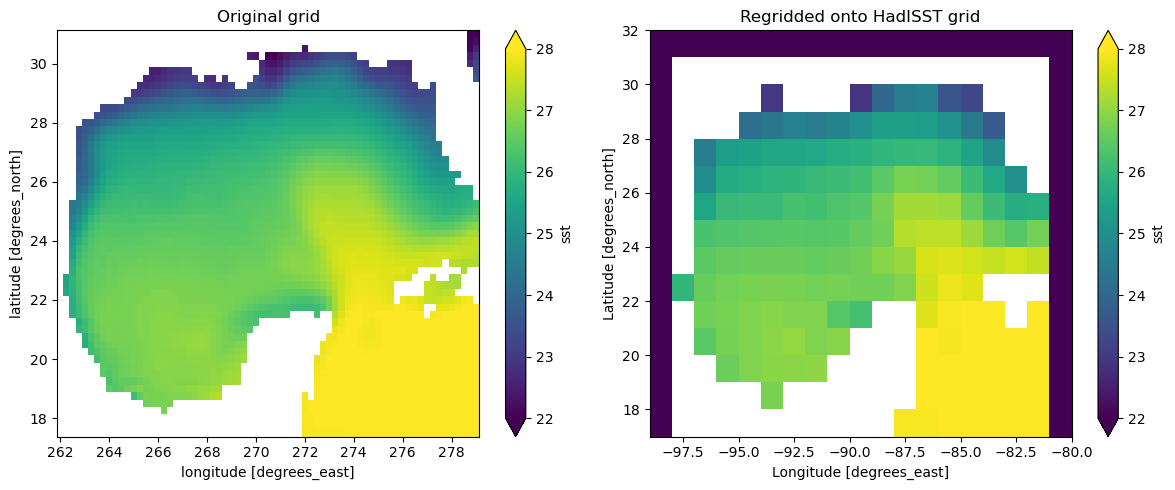

In [48]:
#test to see if regridding didn't change the field too much
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
era.sst.mean('time').plot(ax=ax0, vmin=22, vmax=28)
ax0.set_title('Original grid')
era_ngh.sst.mean('time').plot(ax=ax1, vmin=22, vmax=28)
ax1.set_title('Regridded onto HadISST grid')
plt.tight_layout();

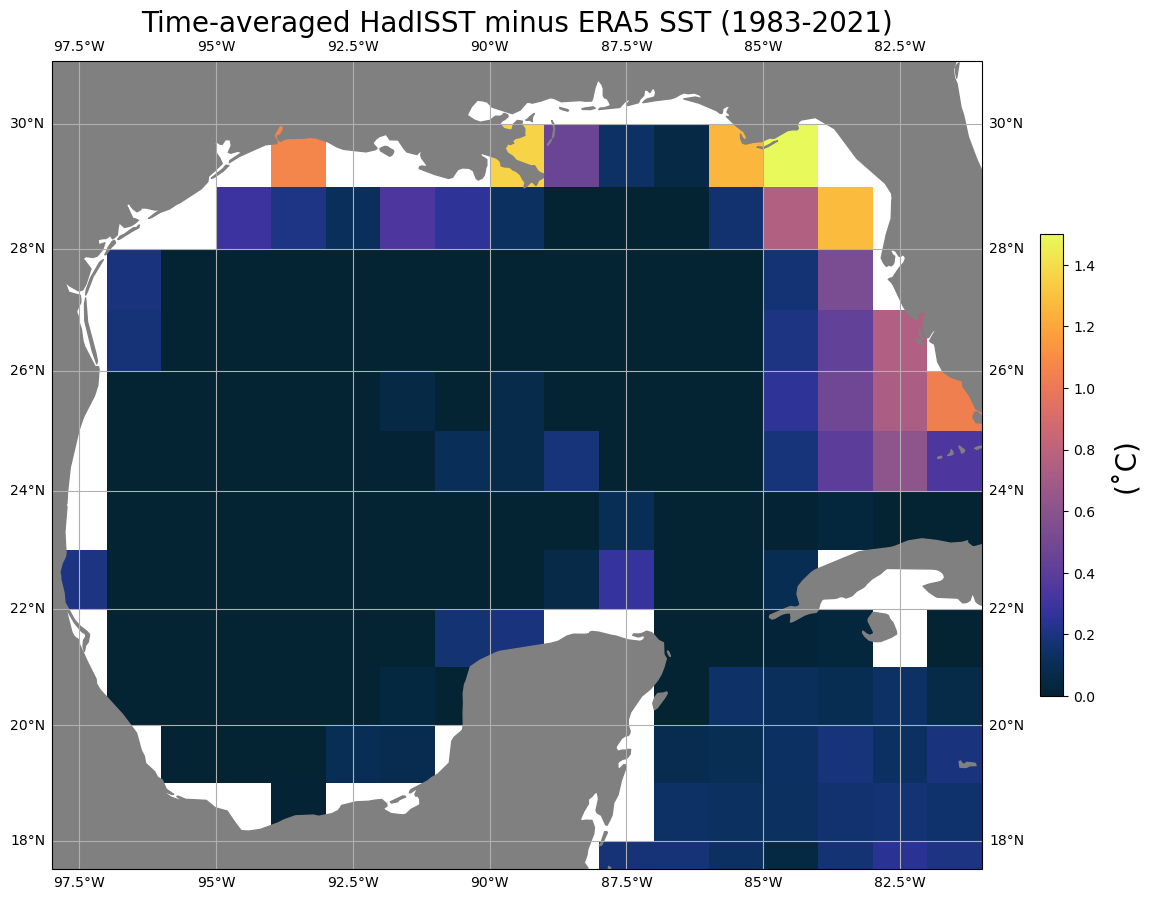

In [59]:
plot_mean((hadisst83-era_ng.sst), cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST minus ERA5 SST (1983-2021)', var_name='hadisst83-era5', vmin=0, vmax=1.5, pcmdi=False)

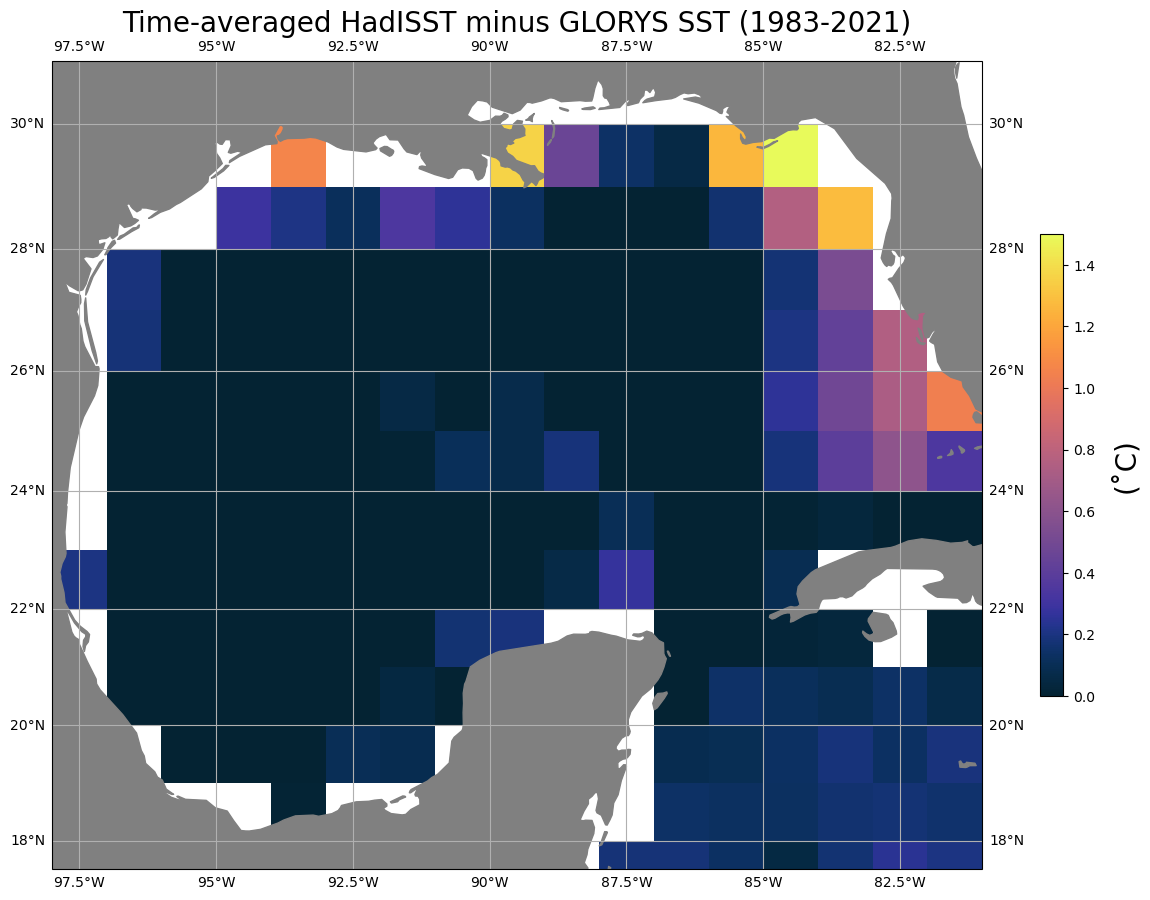

In [60]:
plot_mean((hadisst83-era_ng.sst), cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST minus GLORYS SST (1983-2021)', var_name='hadisst83-glorys', vmin=0, vmax=1.5, pcmdi=False)

In [73]:
esm4_ocean.tos[0].coords

Coordinates:
    time     object 8B 1983-01-01 12:00:00
  * xh       (xh) float64 296B -98.25 -97.75 -97.25 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 264B 17.31 17.73 18.14 18.56 ... 30.24 30.67 31.1

In [74]:
hadisst83[0].coords

Coordinates:
    time       datetime64[ns] 8B 1983-01-16T12:00:00
  * latitude   (latitude) float32 60B 31.5 30.5 29.5 28.5 ... 19.5 18.5 17.5
  * longitude  (longitude) float32 76B -98.5 -97.5 -96.5 ... -82.5 -81.5 -80.5

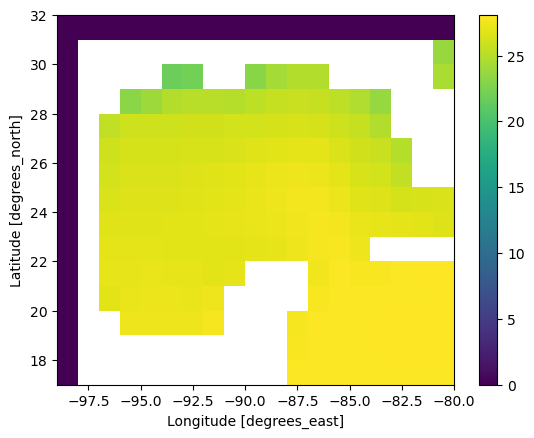

In [63]:
esm_sst_ng.mean('time').plot()

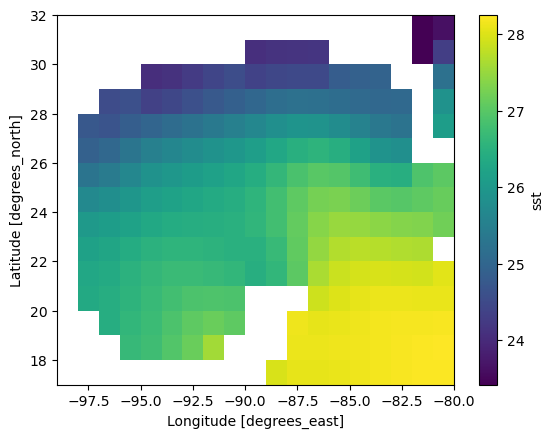

In [76]:
hadisst83.mean('time').plot()

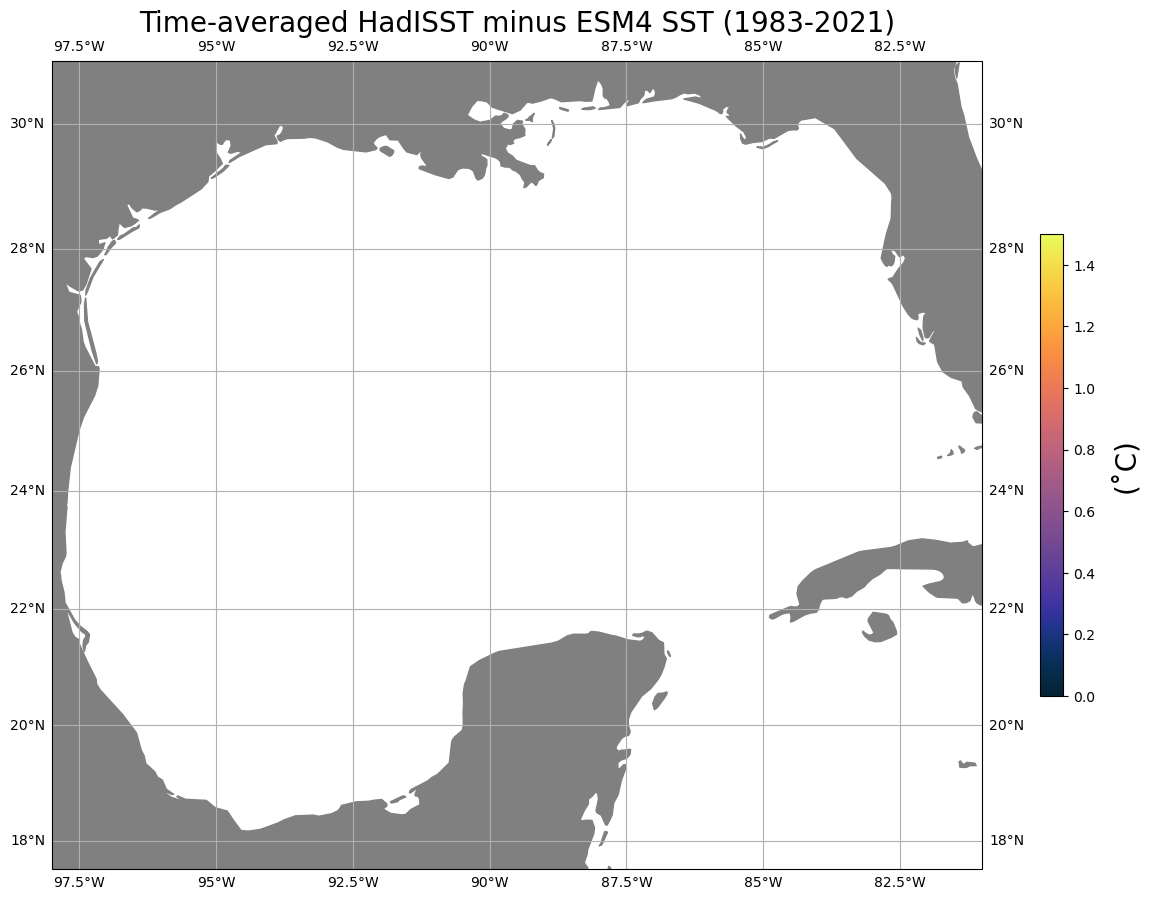

In [61]:
plot_mean((hadisst83-esm_sst_ng), cmap_choice=cmocean.cm.thermal, cbar_label='(˚C)', 
          var_title='HadISST minus ESM4 SST (1983-2021)', var_name='hadisst83-esm4', vmin=0, vmax=1.5, pcmdi=False)